FFNN model

Team Members: Akhila Ganti, Megan Nguyen, Leslie Nie, Kevin Stallone, and Tim Tung 
Github Repo: https://github.com/UC-Berkeley-I-School/mids-207-final-project-summer23-Tung-Ganti-Nie-Nguyen-Stallone.git

Project Description

The goal of this project is to predict if a person has any of three age-related medical conditions. To assess, we will create a model trained on measurements of health characteristics.

Motivation

"Aging is a risk factor for numerous diseases and complications. The growing field of bioinformatics includes research into interventions that can help slow and reverse biological aging and prevent major age-related ailments. Data science could have a role to play in developing new methods to solve problems with diverse data, even if the number of samples is small."

Data Source

Data is sourced from an active (June 2023) Kaggle competition: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview

In [4]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# For hyperparameter tuning
import keras_tuner
from tensorflow import keras

# Unused atm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from mlxtend.plotting import heatmap
from pykeen.ablation import ablation_pipeline

# Stats library
import statsmodels.api as sm

#from .autonotebook import tqdm as notebook_tqdm
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from tabulate import tabulate

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

random.seed(2)
%matplotlib inline

/Users/akhilaganti/anaconda3/lib/python3.10/site-packages/pykeen/evaluation/evaluator.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
greeks = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/greeks.csv')
train = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/train.csv')
test = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/test.csv')

greeks.columns = map(str.lower, greeks.columns)
train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)

print('greeks data:', greeks.shape)
print('train data:', train.shape)
print('test data:', test.shape)

# Merge train and greeks to get all columns in the same DataFrame
#df = pd.merge(train, greeks, on='id')

greeks data: (617, 6)
train data: (617, 58)
test data: (5, 57)


In [6]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

In [7]:
#train.dropna(axis=0, inplace=True)
train.shape

(617, 59)

In [24]:
# Use PCA to reduce features
# Split into Train and Test
num_features = 24
data_split = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
# Standardize values via StandardScaler
sc = StandardScaler().fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# PCA
pca = PCA(n_components = num_features)
pca.fit(X_train_std)
X_train_pca = pd.DataFrame(pca.transform(X_train_std))
X_test_pca = pd.DataFrame(pca.transform(X_test_std))


In [25]:
X_train.shape

(493, 57)

In [26]:
X_train_pca.shape

(493, 24)

In [27]:
Y_train.shape

(493,)

In [28]:
X_test.shape

(124, 57)

In [29]:
X_test_pca.shape

(124, 24)

In [30]:
Y_test.shape

(124,)

In [31]:
Y_test.head()

567    0
117    0
593    0
193    1
437    0
Name: class, dtype: int64

In [32]:
display(Y_test)

567    0
117    0
593    0
193    1
437    0
      ..
66     0
489    0
47     0
31     1
538    1
Name: class, Length: 124, dtype: int64

In [33]:
display(X_train_pca.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train_pca.shape)

0         1         2         3         4         5         6    
0 -0.690887  0.685788  1.006226 -1.171854  0.136816  0.093421 -0.481733  \
1 -0.441772  0.454223  1.462607 -0.617965 -0.293618  0.023432  0.153689   
2  0.671402 -1.941961 -1.723888  0.351624  0.629489  1.202796  1.880502   
3 -1.129595 -1.193760  1.500116 -0.829614  0.123395  0.421081  1.446770   
4 -0.449661  0.533336 -2.227092  1.630291 -0.744035 -0.592698  0.645509   

         7         8         9   ...        14        15        16        17   
0  0.392191 -0.176123 -0.091700  ...  0.838373 -1.056261  0.535441  1.200978  \
1 -1.660740 -0.165092  0.878005  ...  0.786217 -1.216243  0.658438  0.838084   
2  1.530765 -0.002930  0.937556  ...  1.091466  0.823074 -0.526456 -0.124357   
3 -1.168590  0.334539  0.943517  ...  1.113140 -0.061908 -0.002122 -0.511413   
4 -0.155894 -1.008784  0.356228  ... -0.789424  0.171670  0.285349  0.590511   

         18        19        20        21        22        23  
0 -0.158611 -0.077590 -0.139836 -0.224102 -0.726805 -0.018811  
1  0.360564 -0.085385 -0.239045 -0.435239 -0.537305 -0.387489  
2 -0.583080 -0.040892  0.021261  1.472451 -0.945578  0.924031  
3  0.160301  0.051340 -1.812252  0.043625  0.140780 -0.521942  
4 -0.380552 -0.343775 -0.816738 -0.552360 -0.553257 -0.493903  

[5 rows x 24 columns]

(617, 57)

(493, 24)

Model

In [18]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                dropout_rate=0.1):
    
    """Build a binary-class logistic regression model using Keras.

    Args:
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model (graph).
    """
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Create hidden layers with dropout layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=layer_size,activation=activation))
        
        # Add dropout layer for regularization
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
    # Specify optimizer
    if optimizer == 'Adam':
                selected_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model


In [19]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [20]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       dropout_rate=0.1,
                       num_epochs=5,
                       num_folds=10):

  # Address the class imbalances by using class weights.
  # Scaling by total/2 helps keep the loss to a similar magnitude.
  # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / Y_train.value_counts()[0]) * (Y_train.size / 2.0)
    weight_for_1 = (1 / Y_train.value_counts()[1]) * (Y_train.size / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
  # Create a k-fold object with k subsets
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)

  # Create a list to hold the accuracy for each k-fold.
    accuracy_history = []
    
  # Iterate over the k subsets
    for train_index, test_index in kfold.split(X_train_pca):
        X_train_k, X_test_k = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
        Y_train_k, Y_test_k = Y_train.iloc[train_index], Y_train.iloc[test_index]
 
        # Build the model.
        model = build_model(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate,
                      dropout_rate=dropout_rate)

        # Train the model.
        print('Training...')
        history = model.fit(
            x=X_train_k,                # our binary training examples
            y=Y_train_k,                # corresponding binary labels
            epochs=num_epochs,        # number of passes through the training data
            batch_size=32,            # mini-batch size for SGD
            validation_split=0.2,     # use a fraction of the examples for validation
            verbose=0,                # do not display progress output during training
            class_weight=class_weight # use the calculated class weights to address the imbalance
            )

        ######
        #
        # Do you run evaluate on (X_test, Y_test) or (X_test_k, Y_test_k)?
        #
        ######
        
        # Calculate the accuracy of the model
        test_accuracy = model.evaluate(x=X_test_pca, y=Y_test, verbose=0,
                                 return_dict=True)['binary_accuracy']

        print(f'Accuracy: {test_accuracy}')
        
        # Add the accuracy to the history list
        accuracy_history.append(test_accuracy)
        
        # Plot the loss and accuracy
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        ax1, ax2 = axes.ravel()

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax1.plot(train_loss, label='train_loss')
        ax1.plot(val_loss, label='validation loss')
        ax1.set_xticks(range(num_epochs))
        ax1.set_xlabel('Train epochs')
        ax1.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax1.legend()

        train_accuracy = history.history['binary_accuracy']
        val_accuracy = history.history['val_binary_accuracy']
        ax2.plot(train_accuracy, label='train_accuracy')
        ax2.plot(val_accuracy, label='validation accuracy')
        ax2.set_xticks(range(num_epochs))
        ax2.set_xlabel('Train epochs')
        ax2.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax2.legend()

        plt.show()
        
#         # run the trained model on the test data (the model outputs probabilities)
#         Y_test_pred_p = model.predict(x=X_test_pca.values()).flatten()

#         # apply the threshold function to create a 0, 1 outcome
#         Y_test_pred = np.where(Y_test_pred_p>=0.5, 1, 0)
#         y_test_pred[:10] # first 10 only
        
#         # Plot the confusion matrix
#         Y_test_pred = np.where(model.predict(X_test_pca) > 0.5, 1, 0)        
#         confusion_matrix = tf.math.confusion_matrix(Y_test.to_numpy(), Y_pred)

#         sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
#         plt.xlabel('Predicted Labels')
#         plt.ylabel('True Labels')
        
#         plt.show()
    
#         # precision score
#         p = tf.keras.metrics.Precision(
#         thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
#         p.update_state(Y_test, Y_test_pred)  #18/(18+3)
#         print("Precision score: %3f" %p.result().numpy())
    
#         # recall score
#         r = tf.keras.metrics.Recall(
#         thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
#         r.update_state(Y_test, Y_test_pred) #18/(18+1)
#         print("Recall score: %.3f" %r.result().numpy())
    
#         # F1 score
#         print("F1 score:",
#         2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())))
       
#         # ROC AUC
#         from sklearn import datasets, metrics, model_selection, svm
#         fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_test_pred_p)
#         auc = metrics.roc_auc_score(Y_test, Y_test_pred_p)
#         plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,3)))
#         plt.legend(loc=4)
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')

#         # add dummy classifier
#         plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='dummy (chance)', alpha=.8)

#         plt.legend(loc=4)        
#         print('ROC AUC:', np.round(auc,3))
    
        # Print the model summary.
        print(model.summary())
    
        # Print the average accuracy of the k folds.
        print(f'Average Accuracy: {sum(accuracy_history) / len(accuracy_history)}')
    
    return model

In [17]:
def build_and_tune_model(hp):
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=5, max_value=100, step=5),
            activation=hp.Choice('activation', ['relu', 'tanh'])
            ))        
        
    # Choose whether to include a dropout layer and tune the dropout rate
    if hp.Boolean('dropout'):
        model.add(tf.keras.layers.Dropout(rate=(hp.Int('dropout_rate', min_value=10, max_value=50, step=5))*0.01))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))

    # For tuning the learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")              
                  
    # Specify optimizer

    # Only using Adam optimizer if using PCA.
    optimizer = 'Adam'
    
    if optimizer == 'Adam':
        selected_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model

# Tune the model
build_and_tune_model(keras_tuner.HyperParameters())

# Set up tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_and_tune_model,
    objective="val_loss",
    max_trials=300,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="ICR",
)

# Display the tuner search space
tuner.search_space_summary()

# Start tuning - Can specify the number of epochs here.
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Report tuning results
tuner.results_summary()

Trial 300 Complete [00h 03m 54s]
val_loss: 0.47174400091171265

Best val_loss So Far: 0.44684577981630963
Total elapsed time: 03h 59m 04s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/ICR
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 121 summary
Hyperparameters:
num_layers: 2
units_0: 75
activation: tanh
dropout: True
lr: 0.009059091318309908
units_1: 90
dropout_rate: 40
units_2: 95
Score: 0.44684577981630963

Trial 063 summary
Hyperparameters:
num_layers: 3
units_0: 80
activation: tanh
dropout: False
lr: 0.005407624490575333
units_1: 55
dropout_rate: 30
units_2: 75
Score: 0.45002317428588867

Trial 117 summary
Hyperparameters:
num_layers: 2
units_0: 75
activation: tanh
dropout: True
lr: 0.006684722663543113
units_1: 40
dropout_rate: 10
units_2: 95
Score: 0.4514497220516205

Trial 068 summary
Hyperparameters:
num_layers: 2
units_0: 75
activation: tanh
dropout: False
lr: 0.00966955488917958
units_1: 15
dropout_rate: 15
units_2: 10
Sc

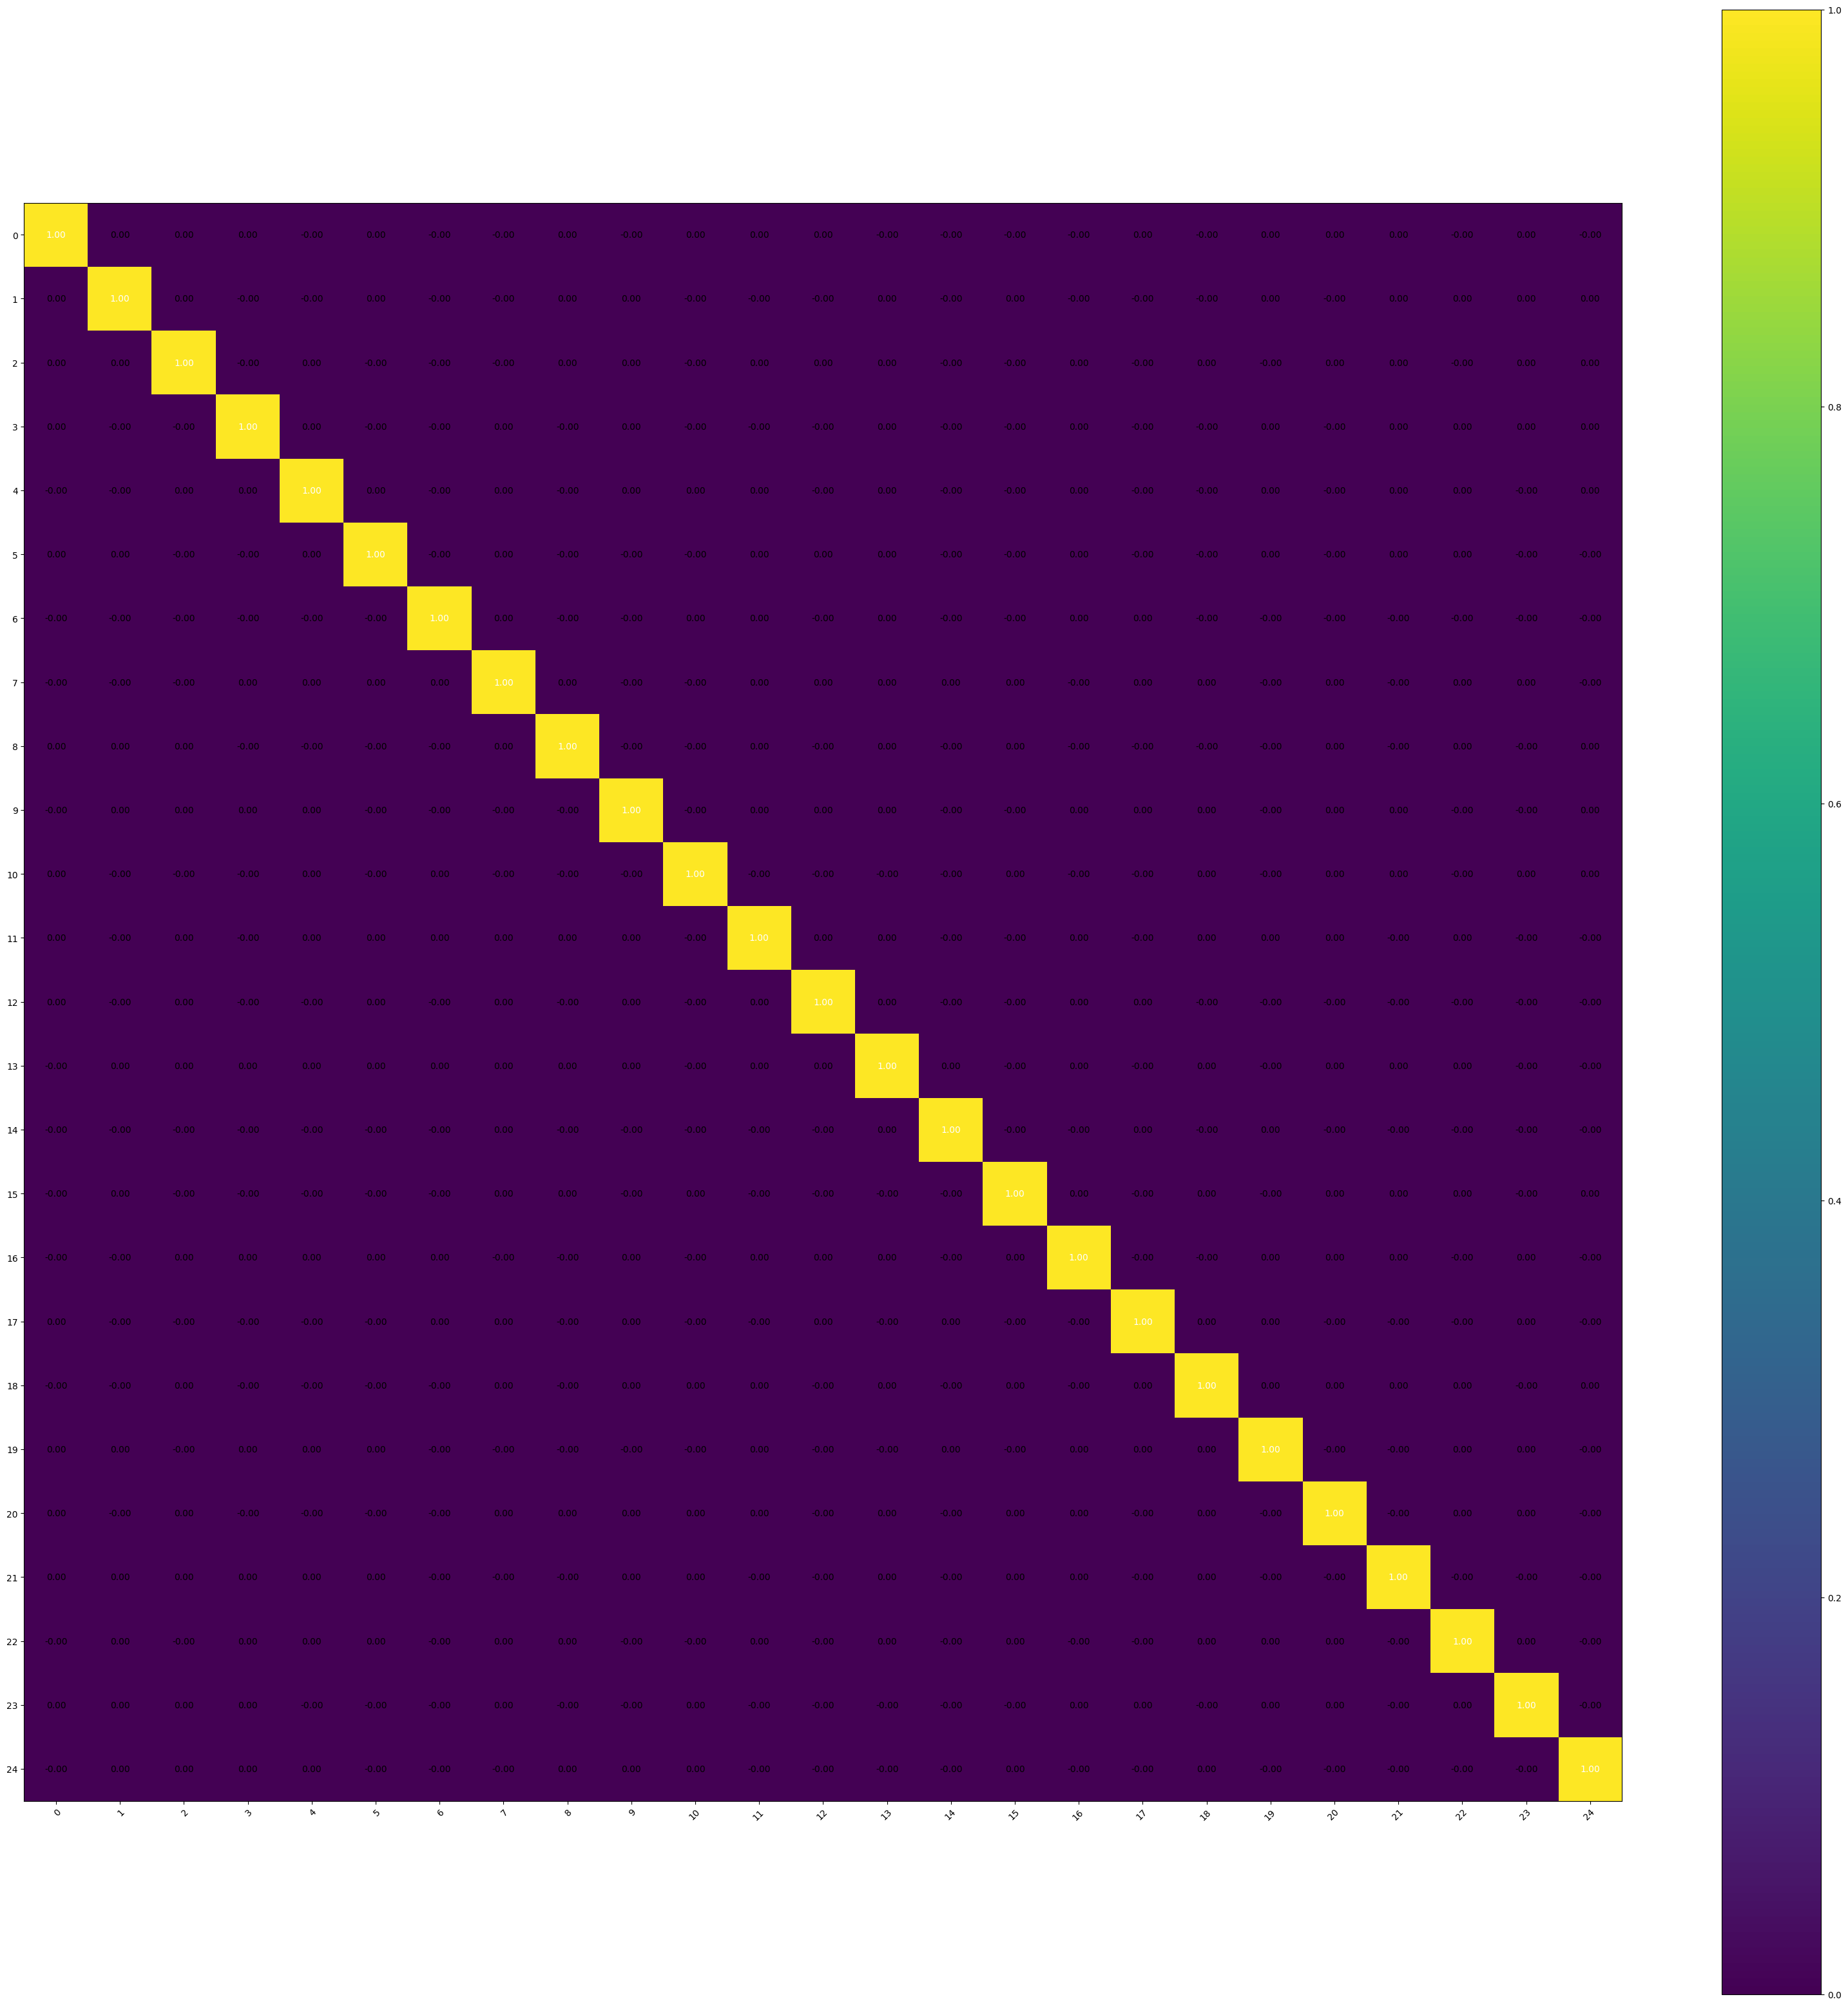

In [21]:
X_train_pca
cm = X_train_pca.corr(numeric_only=True).values
hm = heatmap(
    cm,
    row_names=X_train_pca.columns,
    column_names=X_train_pca.columns,
    figsize=(40, 40)
)

In [19]:
# train_and_evaluate(
#     hidden_layer_sizes=[95,10],
#     activation='relu',
#     optimizer='Adam',
#     learning_rate=0.0012104,
#     dropout_rate=0.25,
#     num_epochs=100,
#     num_folds=10)

Training...
Accuracy: 0.8790322542190552


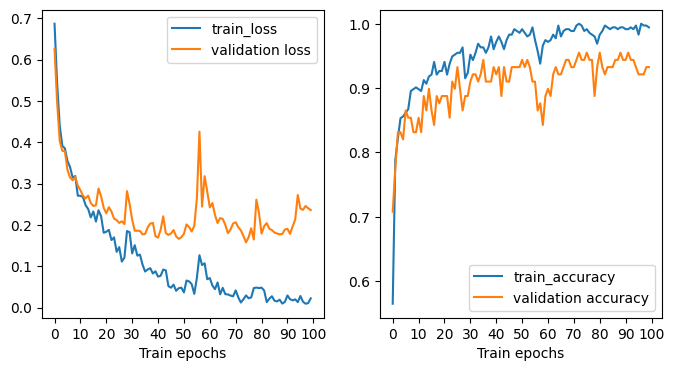

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322542190552
Training...


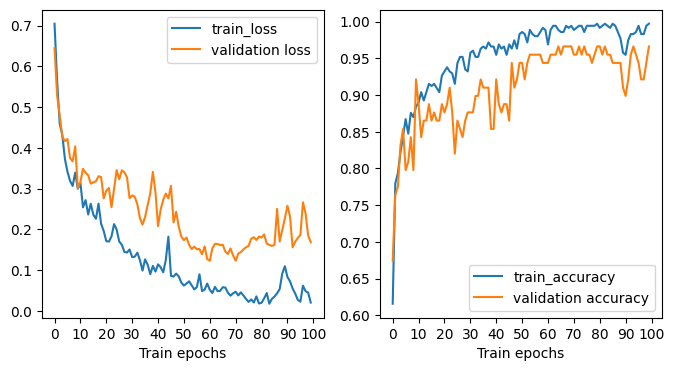

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8870967626571655
Training...


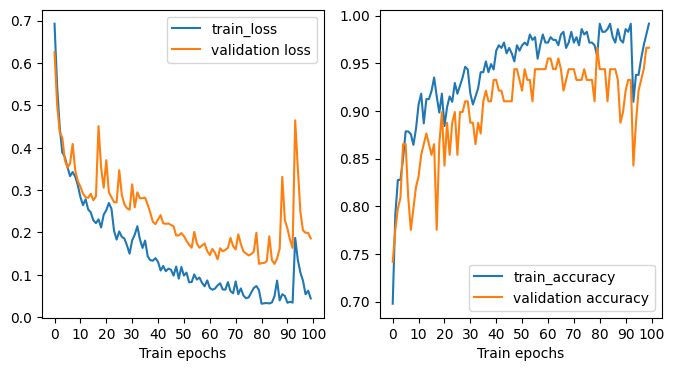

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8817204236984253
Training...


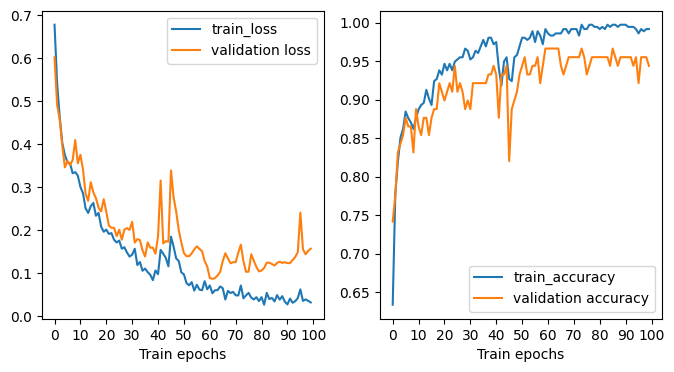

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8891128897666931
Training...


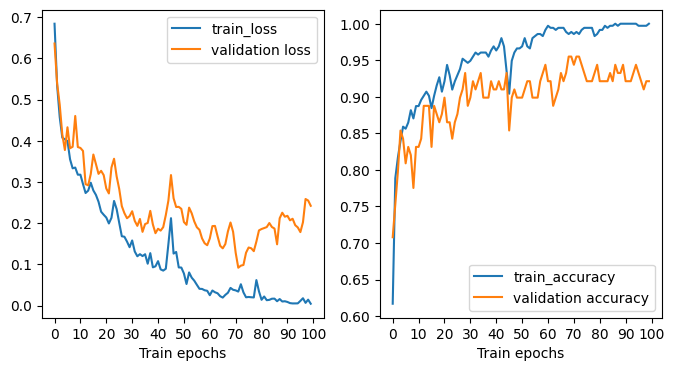

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8919354677200317
Training...


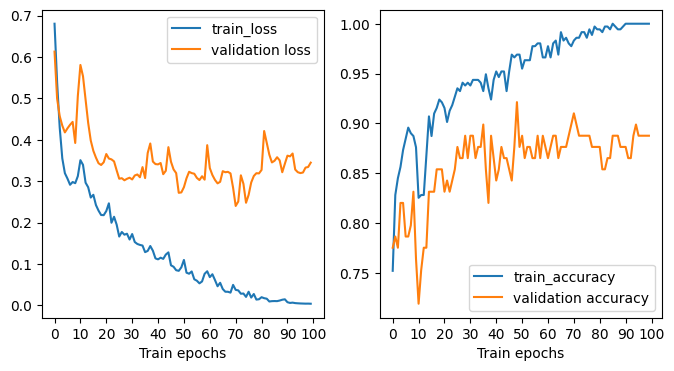

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8884408473968506
Training...


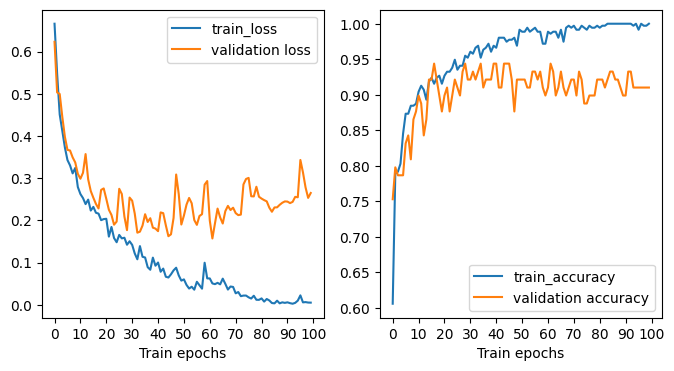

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8882488352911813
Training...


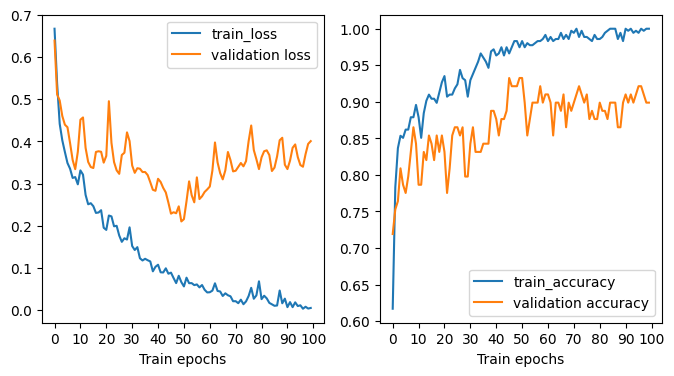

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8860886991024017
Training...


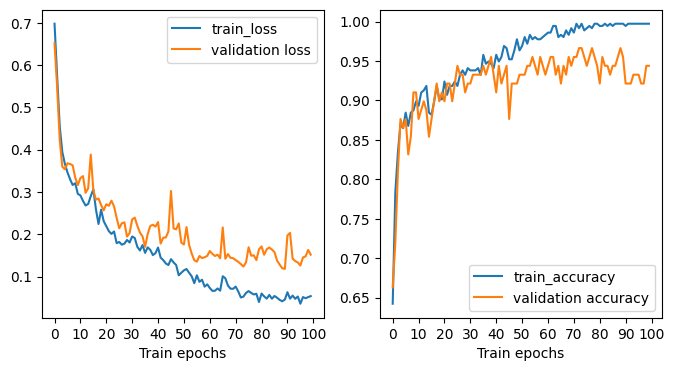

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8835125300619338
Training...


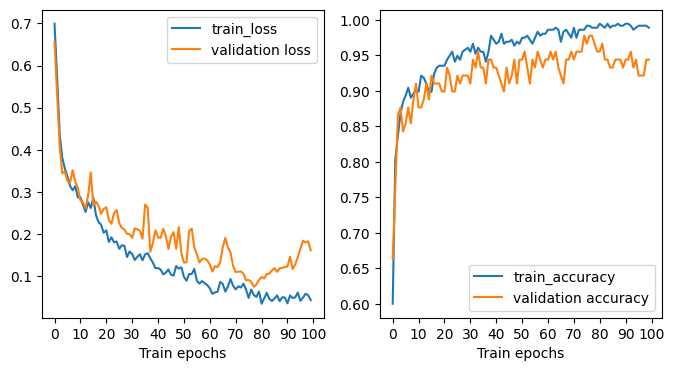

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.884677404165268


In [51]:
train_and_evaluate(
      hidden_layer_sizes=[95,10],
      activation='tanh',
      optimizer='Adam',
      learning_rate=0.006404687722635315,
      dropout_rate=0.1,
      num_epochs=100,
      num_folds=10)

In [52]:
# #dummy classifier
clf = DummyClassifier() # uses Sklearn 

scores = cross_val_score(clf, X_train_pca, Y_train)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.826 (+/- 0.01)


In [53]:
# predictions on test data
# run the trained model on the test data (the model outputs probabilities)
Y_test_pred_p = model.predict(x=X_test_pca).flatten()

# apply the threshold function to create a 0, 1 outcome
Y_test_pred = np.where(Y_test_pred_p>=0.5, 1, 0)
Y_test_pred[:10] # first 10 only

4/4 [==============================] - 1s 205ms/step


array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

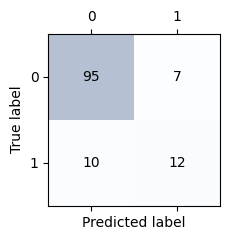

In [54]:
# confussion matrix
conf_matrix = tf.math.confusion_matrix(
    Y_test,
    Y_test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

confusion_matrix_plot(conf_matrix.numpy())

In [55]:
# Precision score
# note that TensorFlow assumes that the positive class is cultivar 1
p = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
p.update_state(Y_test, Y_test_pred)  #18/(18+3)
print("Precision score: %3f" %p.result().numpy())

Precision score: 0.631579


In [56]:
# Recall score
# note that TensorFlow assumes that the positive class is cultivar 1
r = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
r.update_state(Y_test, Y_test_pred) #18/(18+1)
print("Recall score: %.3f" %r.result().numpy())

Recall score: 0.545


In [57]:
# F1 score
print("F1 score:",
    2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())))

F1 score: 0.5853658318519592


ROC AUC: 0.836


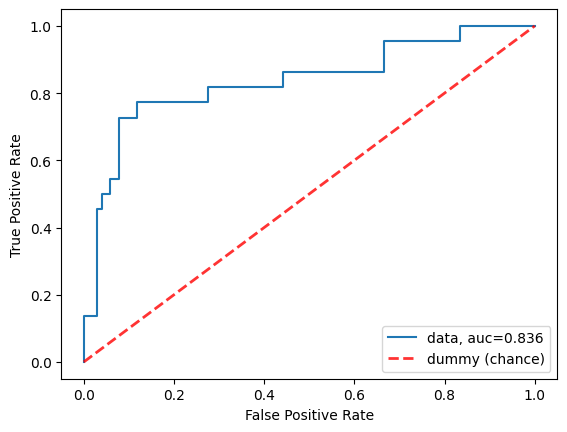

In [58]:
# ROC AUC
from sklearn import datasets, metrics, model_selection, svm
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_test_pred_p)
auc = metrics.roc_auc_score(Y_test, Y_test_pred_p)
plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,3)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


# add dummy classifier
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='dummy (chance)', alpha=.8)

plt.legend(loc=4)
print('ROC AUC:', np.round(auc,3))

Training...
Accuracy: 0.8870967626571655


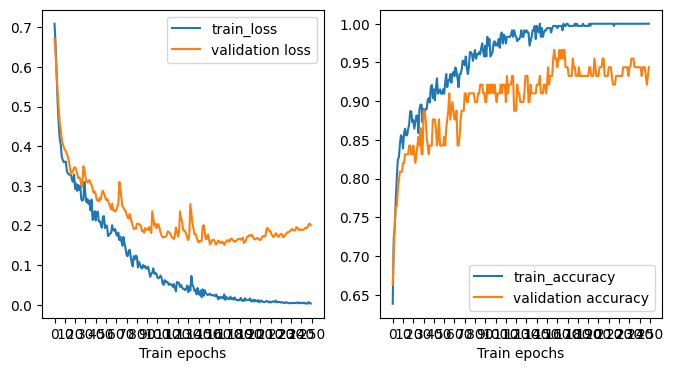

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8870967626571655
Training...


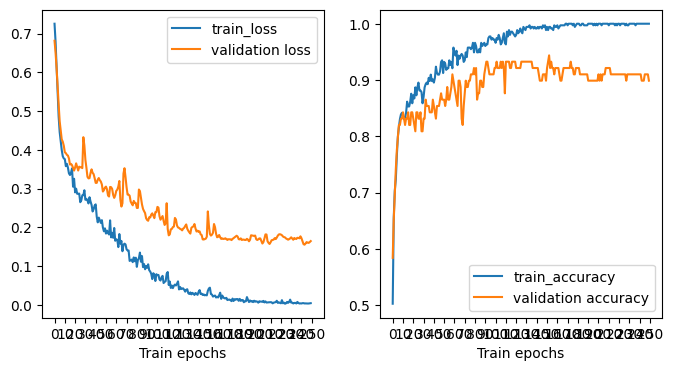

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322542190552
Training...


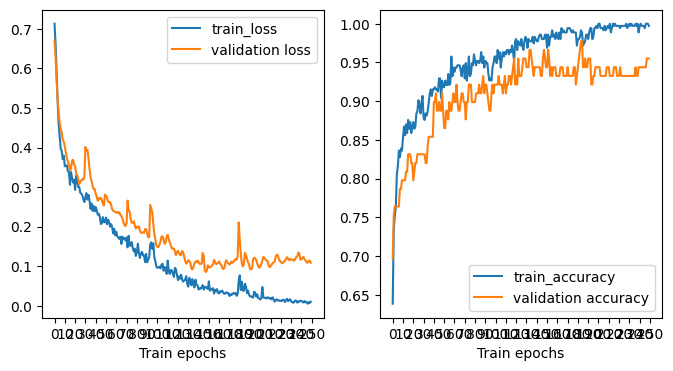

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8817204236984253
Training...


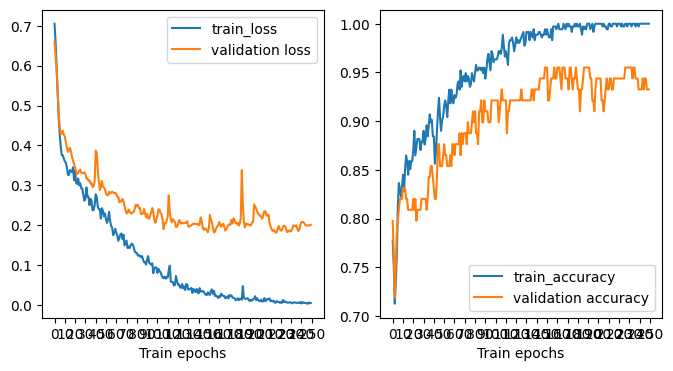

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8830645084381104
Training...


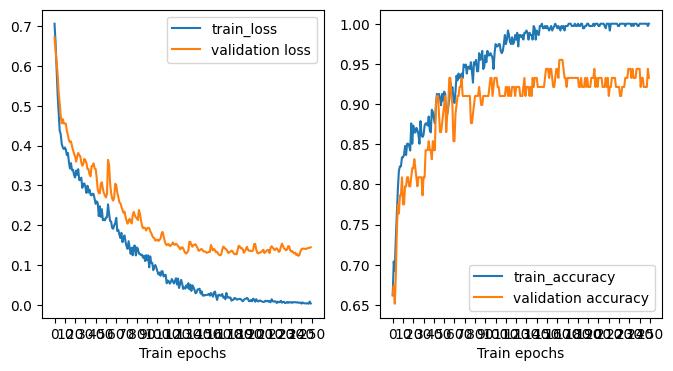

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8822580575942993
Training...


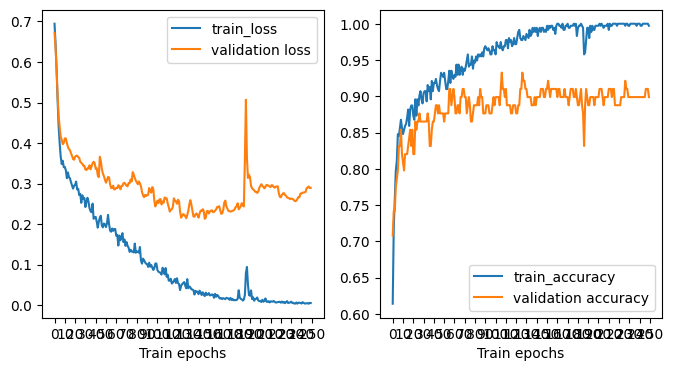

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8857526779174805
Training...


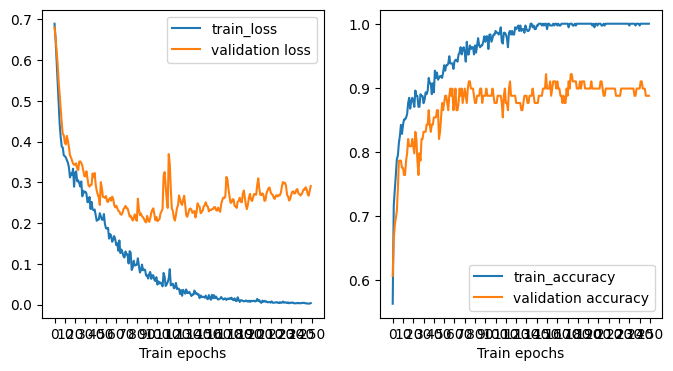

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8870967626571655
Training...


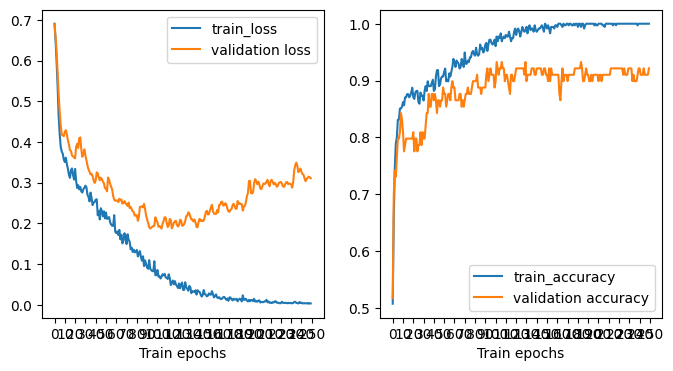

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8891128897666931
Training...


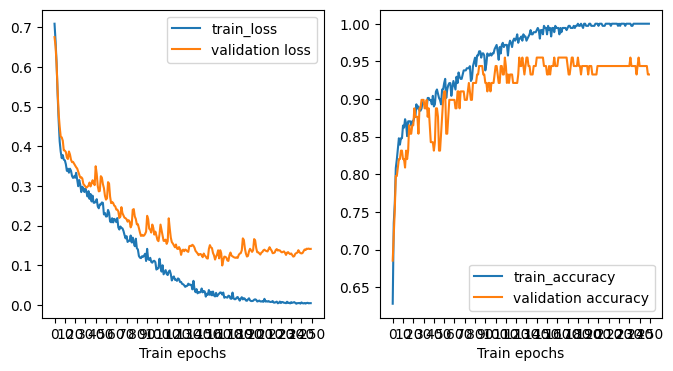

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8879928191502889
Training...


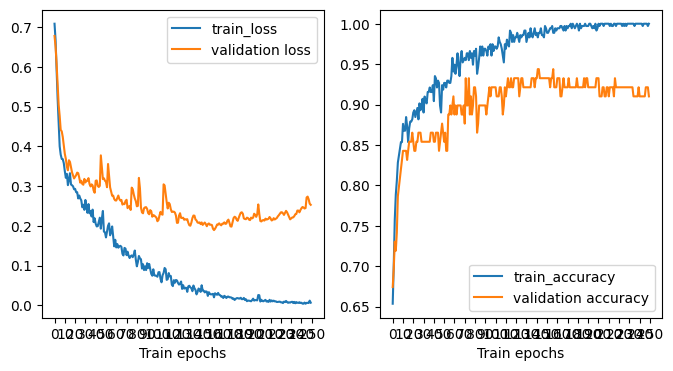

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8887096643447876


In [59]:
train_and_evaluate(
      hidden_layer_sizes=[100,50],
      activation='tanh',
      optimizer='Adam',
      learning_rate=0.001244,
      dropout_rate=0.25,
      num_epochs=250,
      num_folds=10)

In [60]:
# predictions on test data
# run the trained model on the test data (the model outputs probabilities)
Y_test_pred_p = model.predict(x=X_test_pca).flatten()

# apply the threshold function to create a 0, 1 outcome
Y_test_pred = np.where(Y_test_pred_p>=0.5, 1, 0)
Y_test_pred[:10] # first 10 only

4/4 [==============================] - 2s 238ms/step


array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

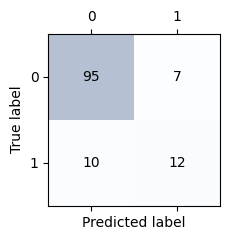

In [61]:
# confussion matrix
conf_matrix = tf.math.confusion_matrix(
    Y_test,
    Y_test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

confusion_matrix_plot(conf_matrix.numpy())

In [62]:
# Precision score
# note that TensorFlow assumes that the positive class is cultivar 1
p = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
p.update_state(Y_test, Y_test_pred)  #18/(18+3)
print("Precision score: %3f" %p.result().numpy())

Precision score: 0.631579


In [63]:
# Recall score
# note that TensorFlow assumes that the positive class is cultivar 1
r = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
r.update_state(Y_test, Y_test_pred) #18/(18+1)
print("Recall score: %.3f" %r.result().numpy())

Recall score: 0.545


In [64]:
# F1 score
print("F1 score:",
    2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())))

F1 score: 0.5853658318519592


ROC AUC: 0.836


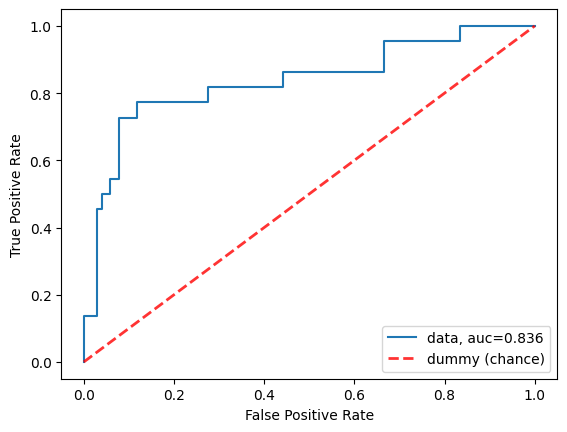

In [65]:
# ROC AUC
from sklearn import datasets, metrics, model_selection, svm
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_test_pred_p)
auc = metrics.roc_auc_score(Y_test, Y_test_pred_p)
plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,3)))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


# add dummy classifier
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='dummy (chance)', alpha=.8)

plt.legend(loc=4)
print('ROC AUC:', np.round(auc,3))

Metal device set to: Apple M1 Max
Training...
Accuracy: 0.8709677457809448


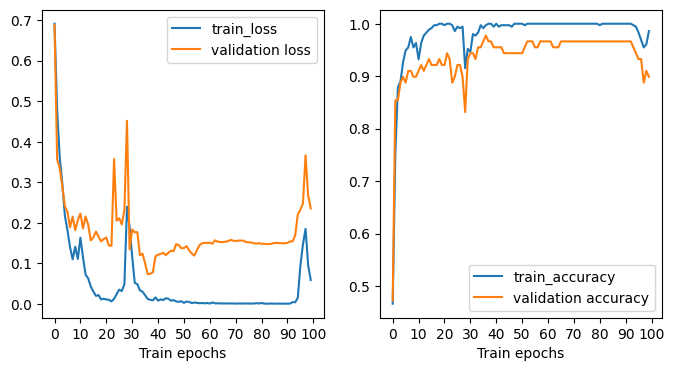

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8709677457809448
Training...


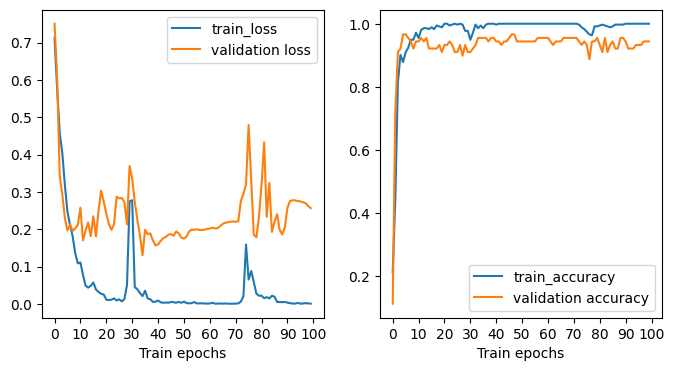

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8709677457809448
Training...


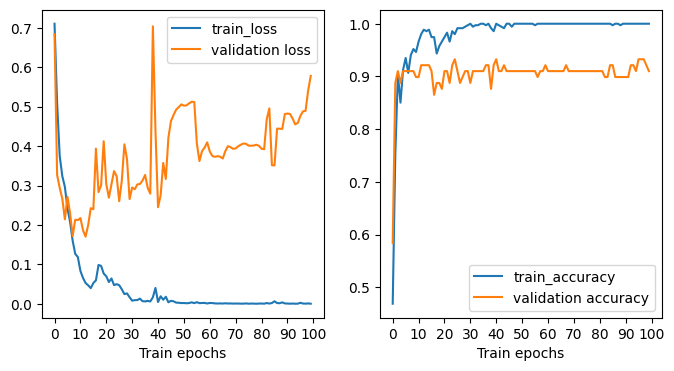

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8763440847396851
Training...


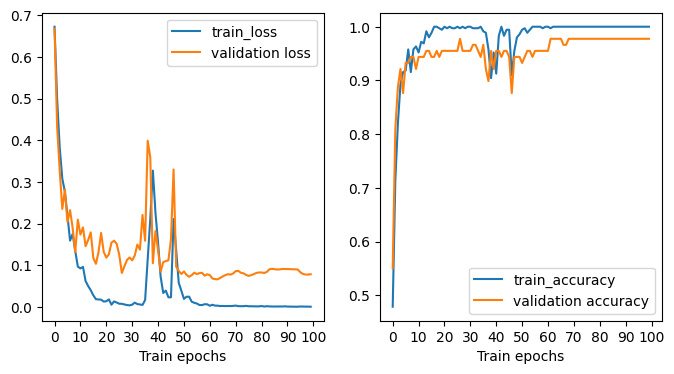

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8810483813285828
Training...


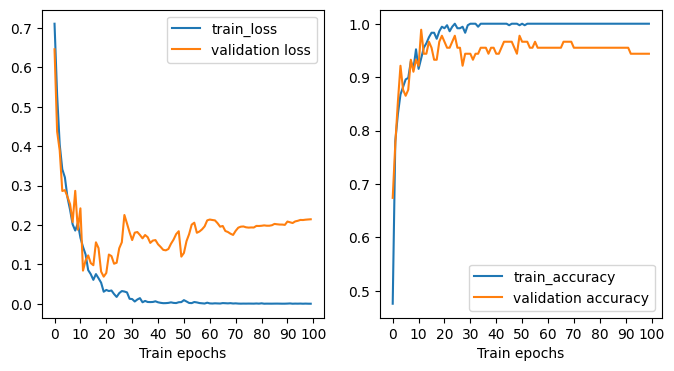

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8854838609695435
Training...


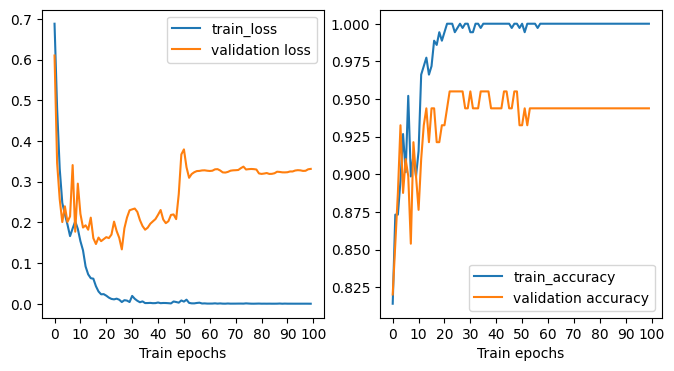

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8870967626571655
Training...


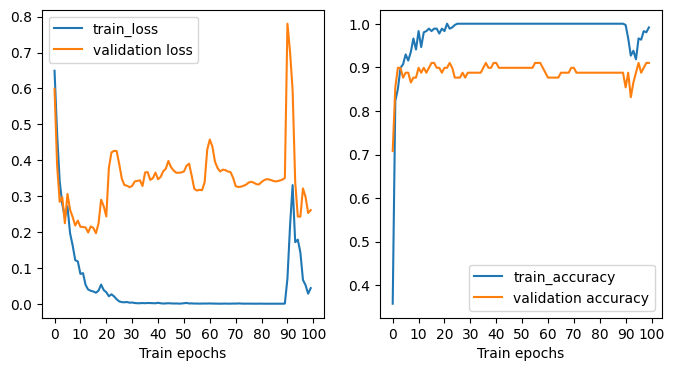

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8859446900231498
Training...


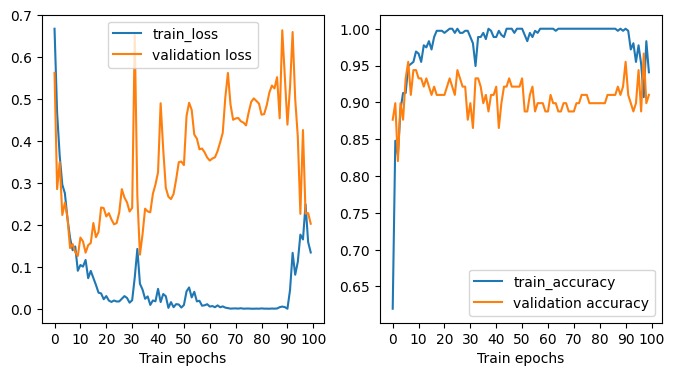

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8830645009875298
Training...


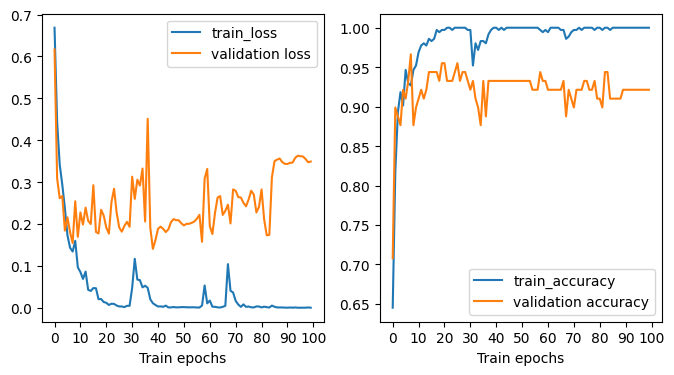

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8826164735688103
Training...


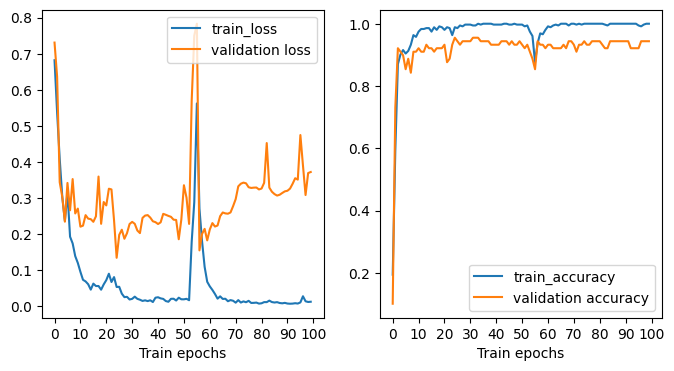

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8782257914543152
Training...


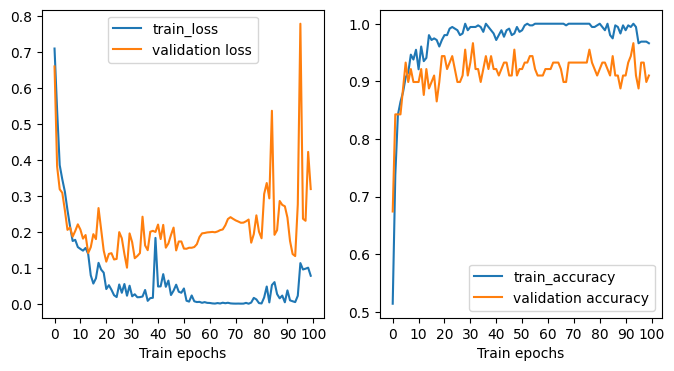

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8387096524238586
Training...


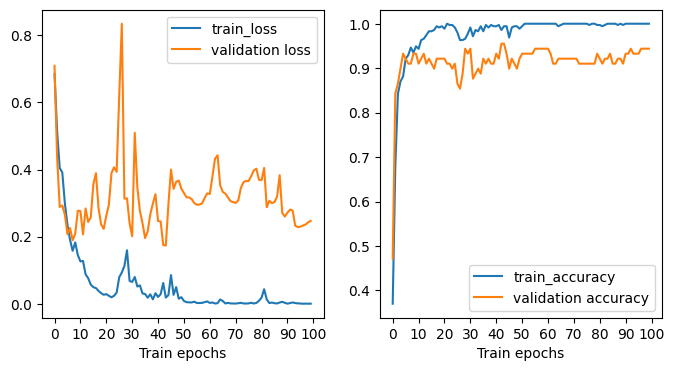

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8588709533214569
Training...


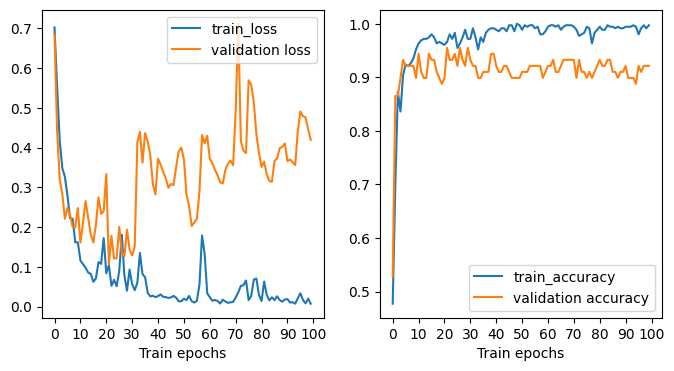

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8709677259127299
Training...


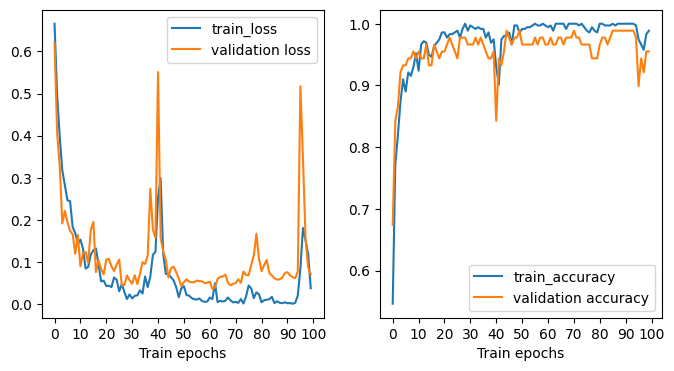

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8689515888690948
Training...


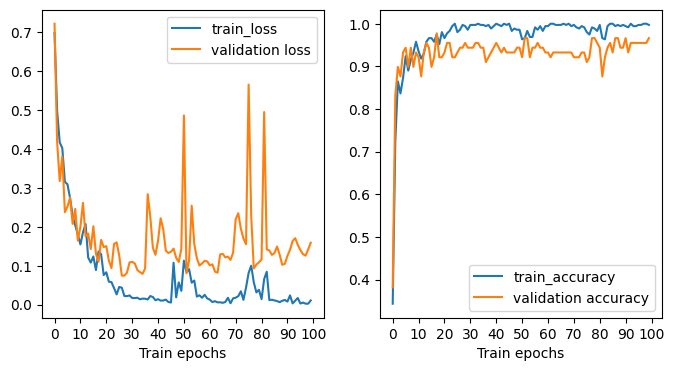

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8693548202514648
Training...


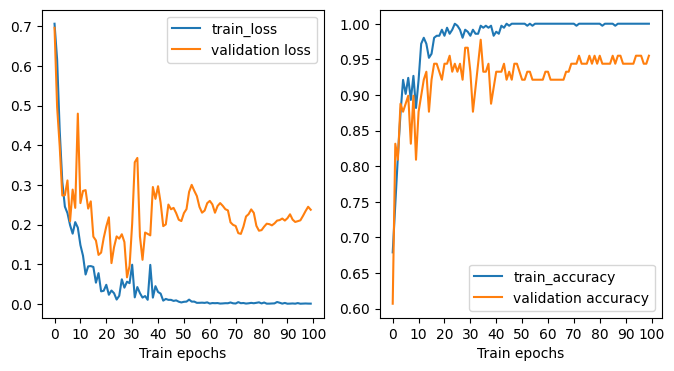

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8709677259127299
Training...


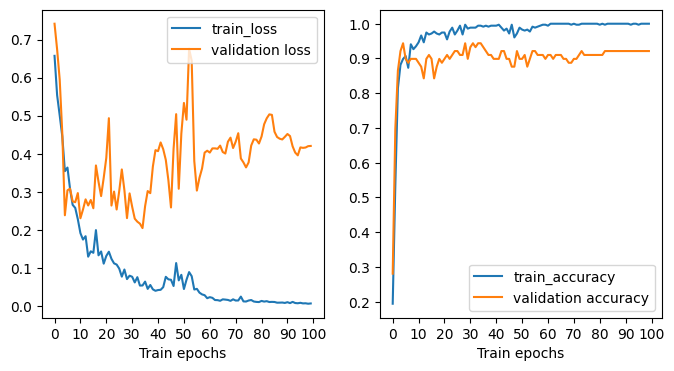

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8721198013850621
Training...


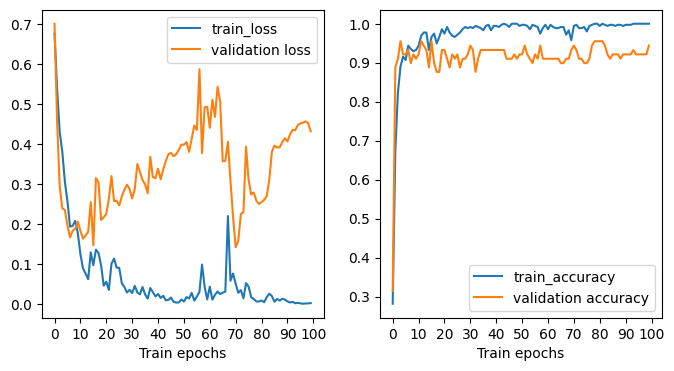

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.873991921544075
Training...
A

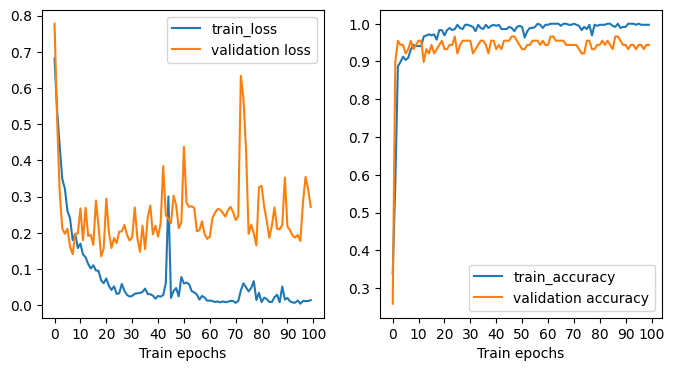

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8718637824058533
Training...


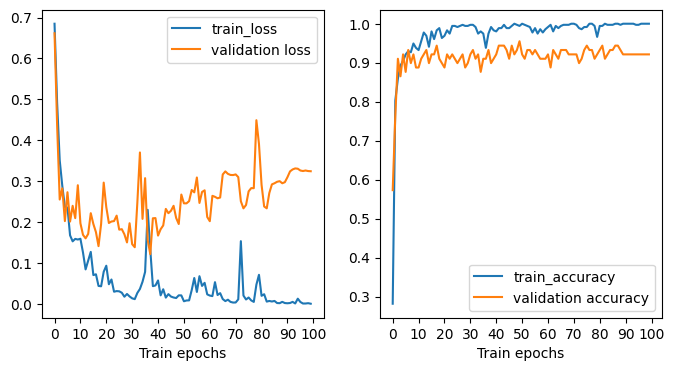

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8717741787433624
Training...


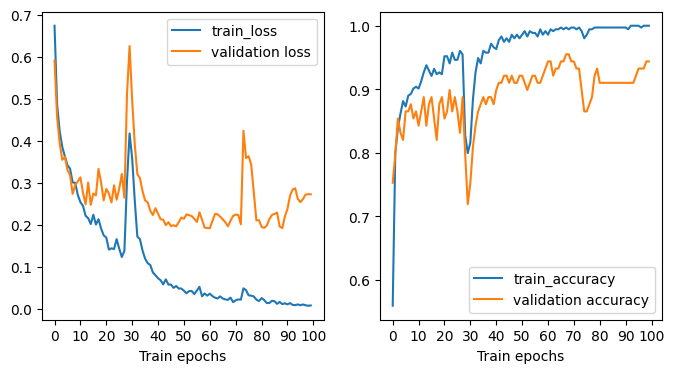

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8709677457809448
Training...


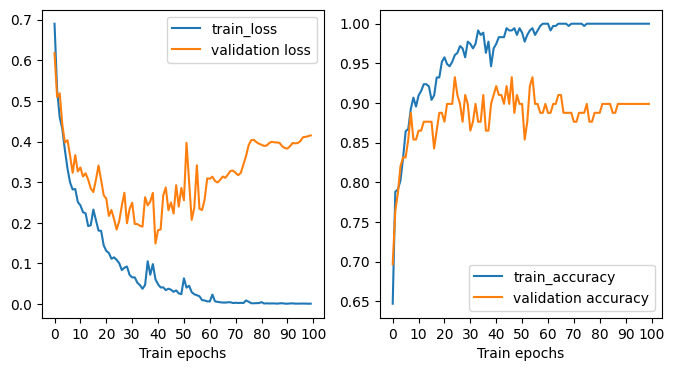

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.875
Training...
Accuracy: 0.8

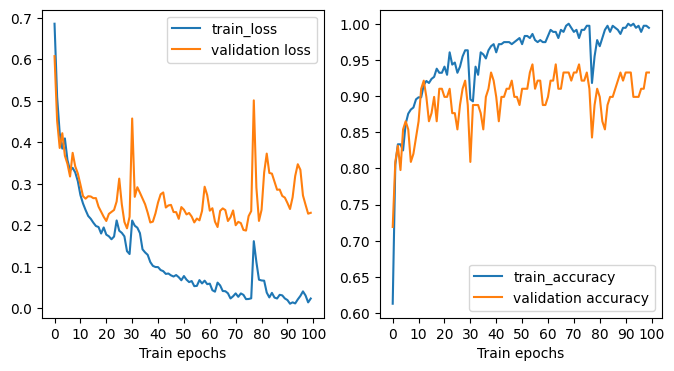

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8682795564333597
Training...


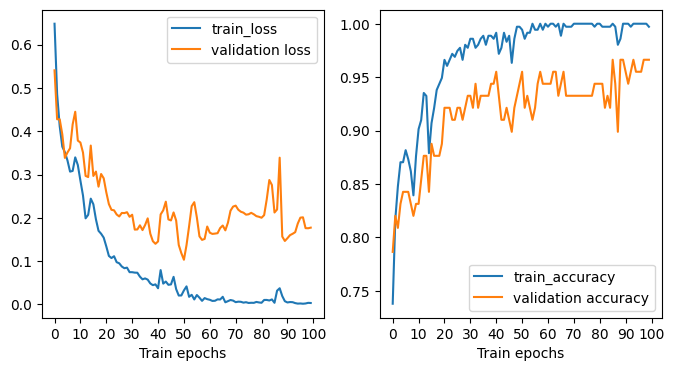

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8729838579893112
Training...


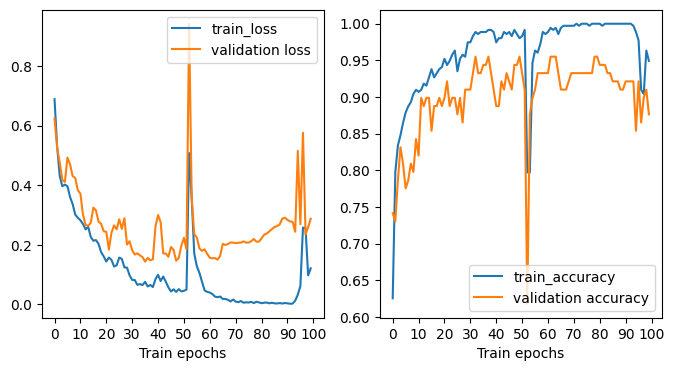

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.872580635547638
Training...
A

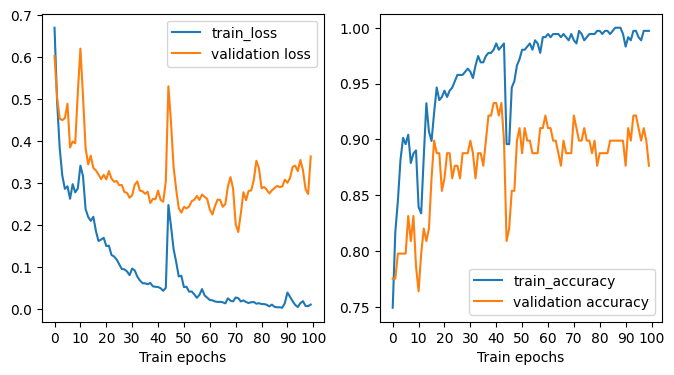

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8736559053262075
Training...


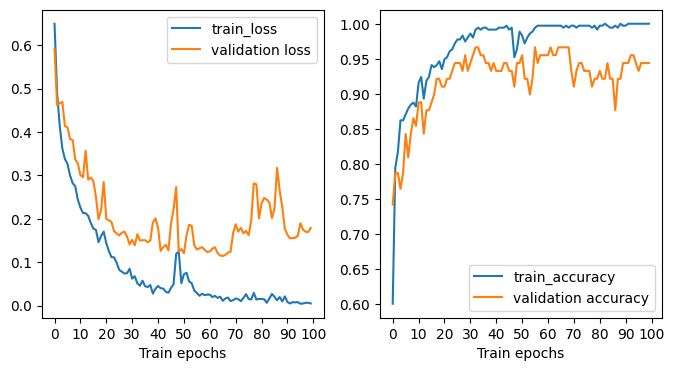

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8721198013850621
Training...


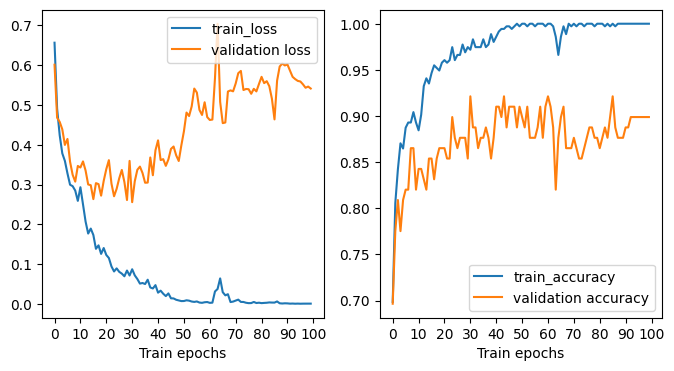

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8719757944345474
Training...


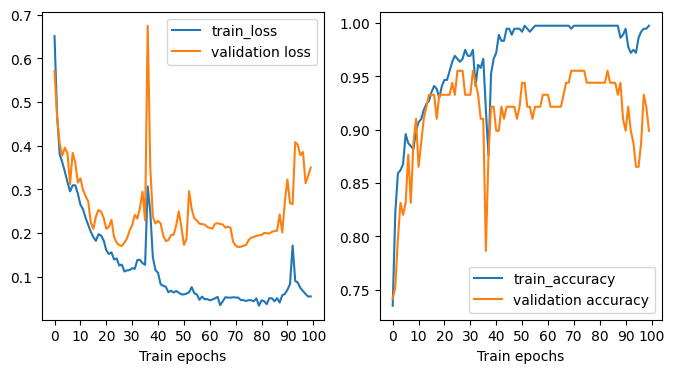

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8718637890285916
Training...


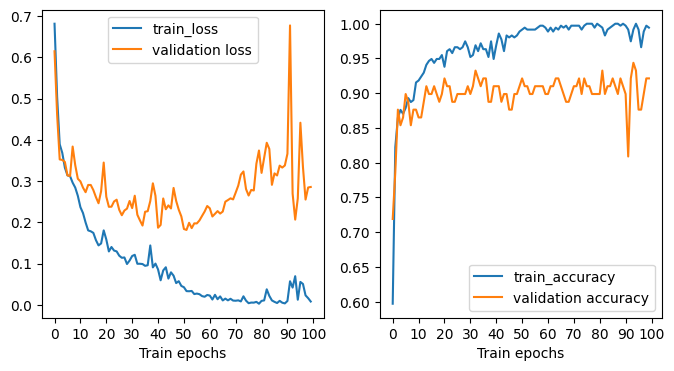

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.871774184703827
Training...
A

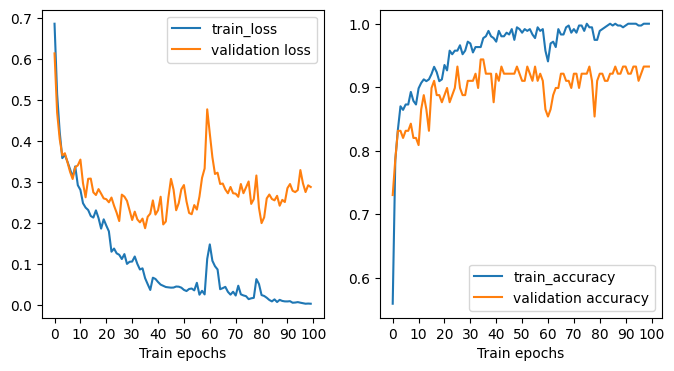

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8709677457809448
Training...


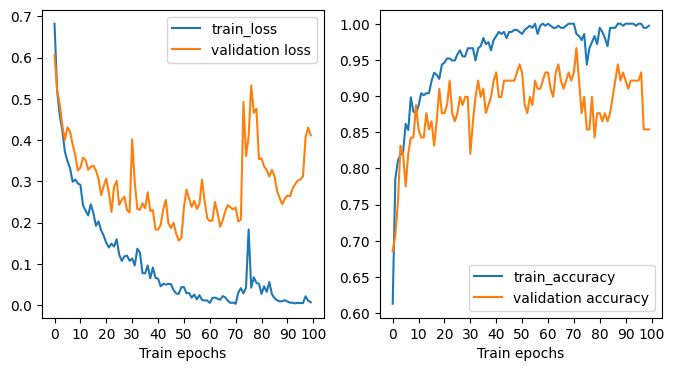

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322542190552
Training...


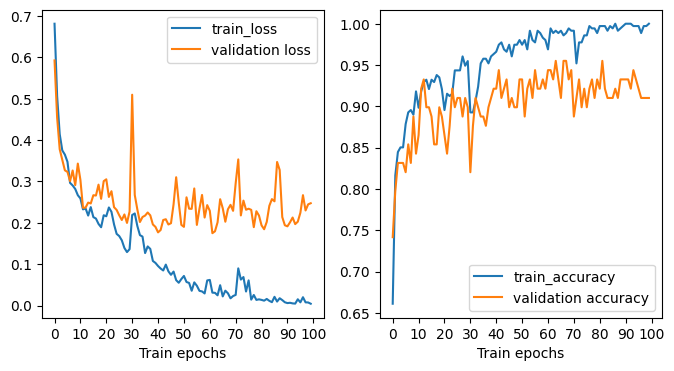

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8817204236984253
Training...


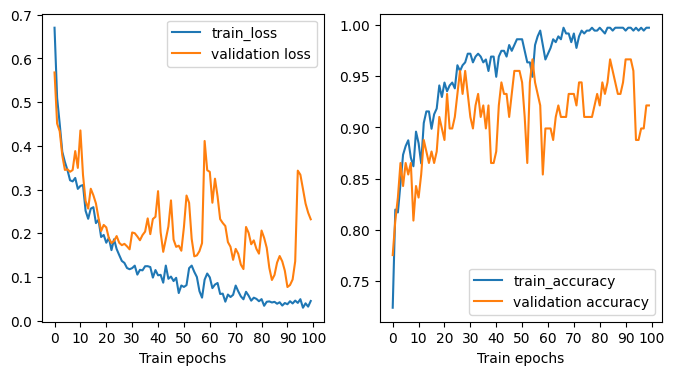

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322542190552
Training...


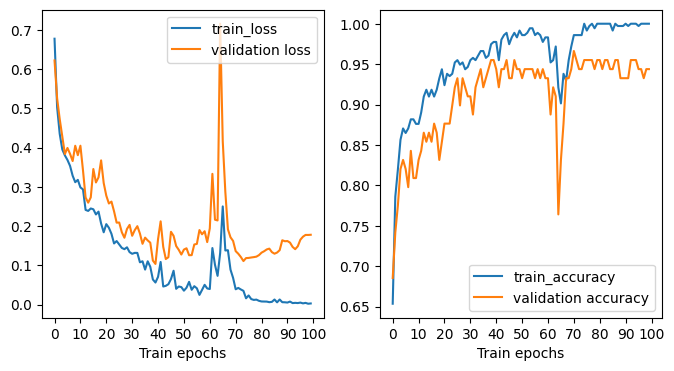

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8838709592819214
Training...


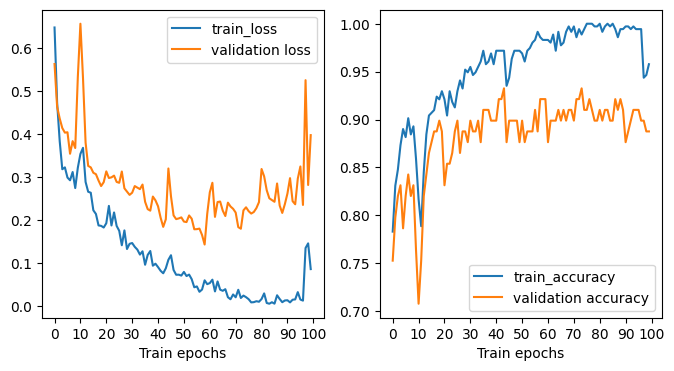

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8736559053262075
Training...


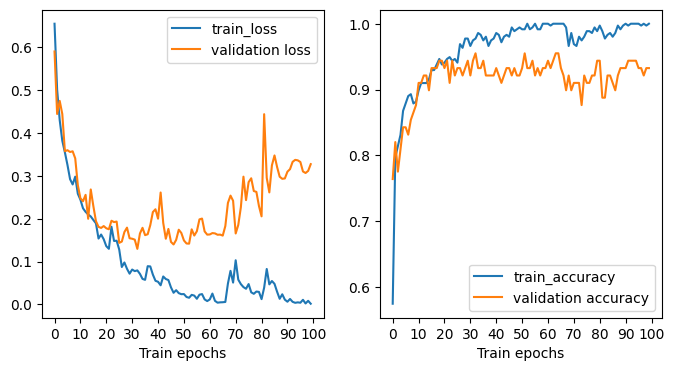

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8767281004360744
Training...


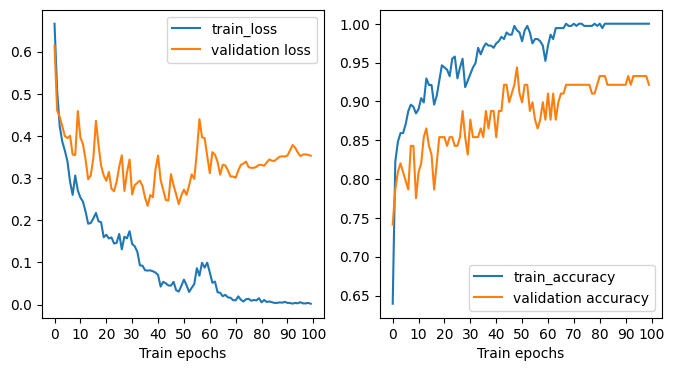

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8780241832137108
Training...


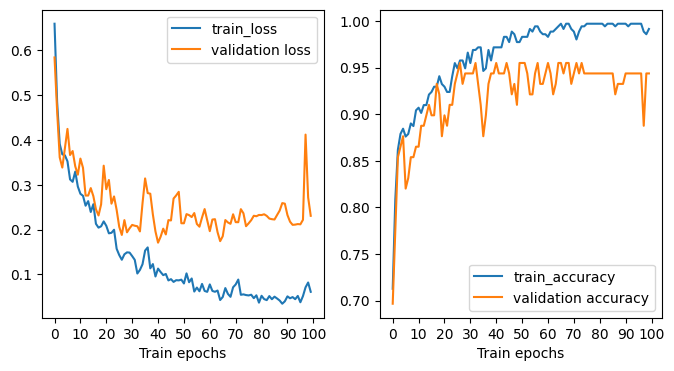

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8772401346100701
Training...


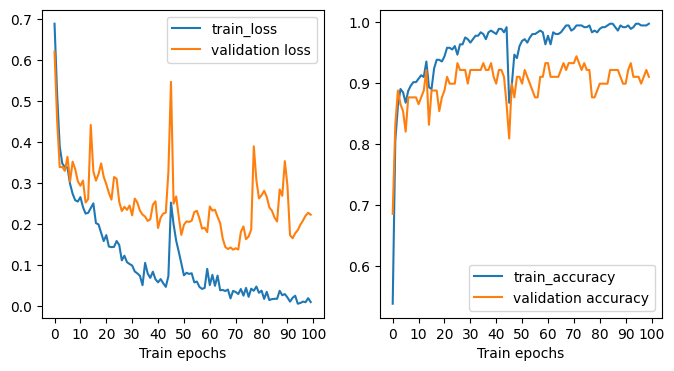

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8798386991024018
Training...


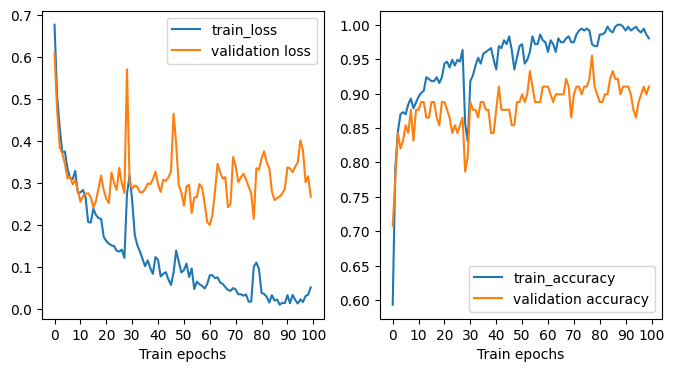

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8629031777381897
Training...


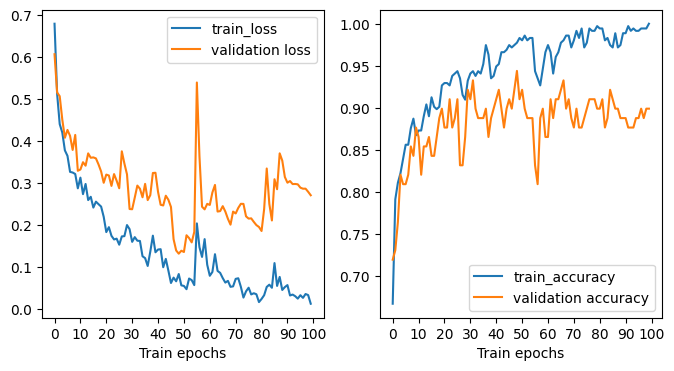

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322244167328
Training...


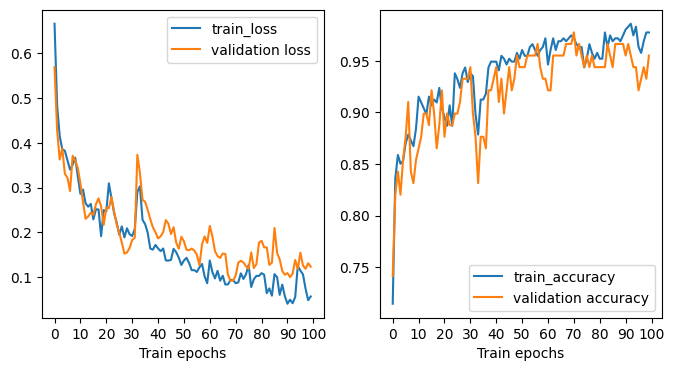

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322343508402
Training...


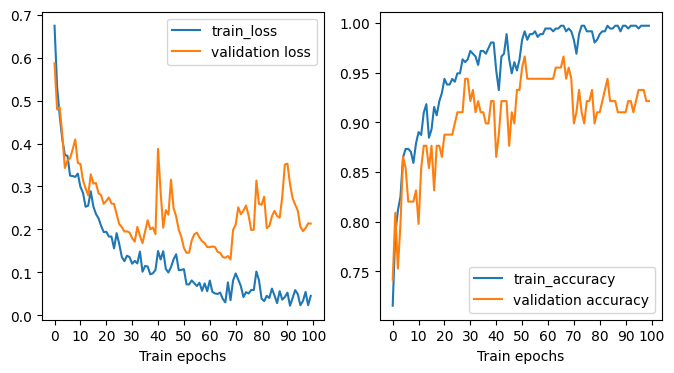

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8830644935369492
Training...


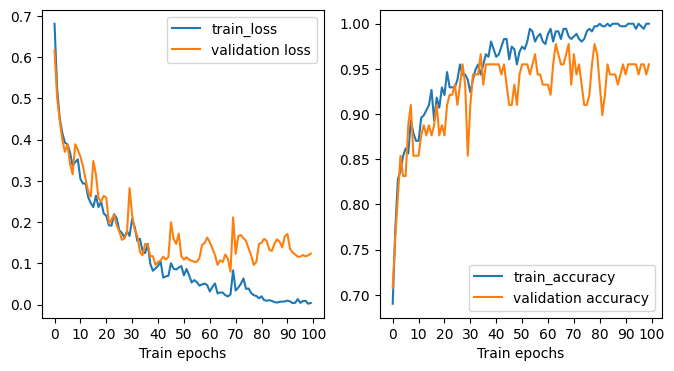

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8854838490486145
Training...


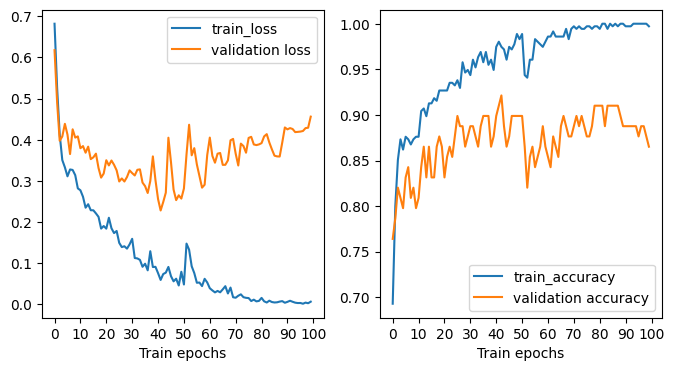

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8884408374627432
Training...


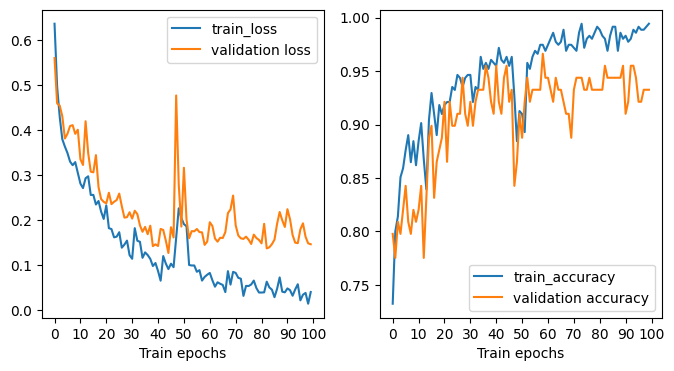

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8894008994102478
Training...


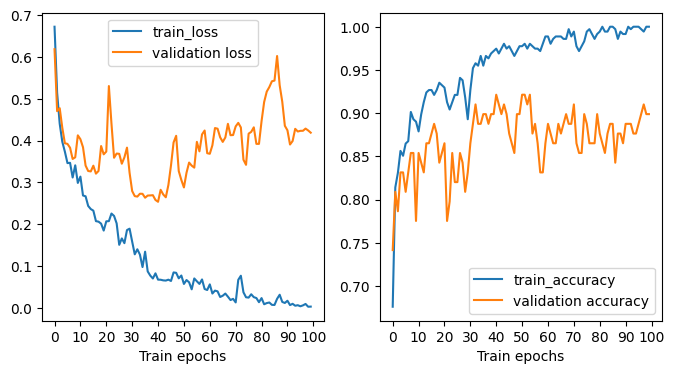

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8911290094256401
Training...


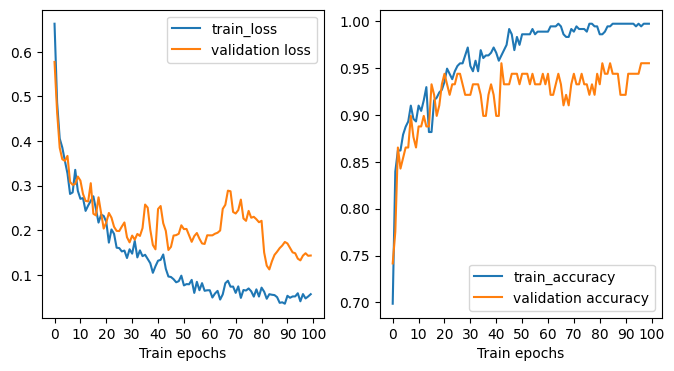

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8906809820069207
Training...


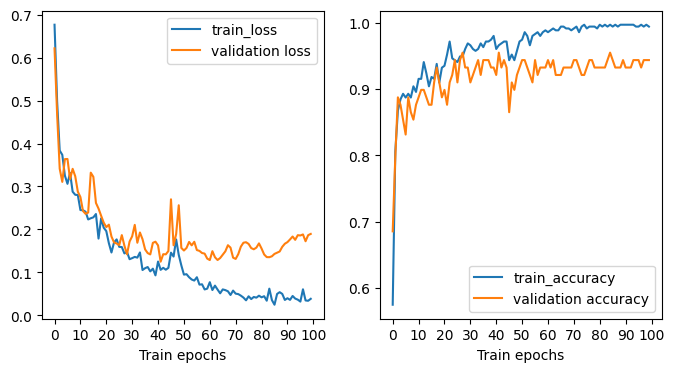

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8903225600719452
Training...


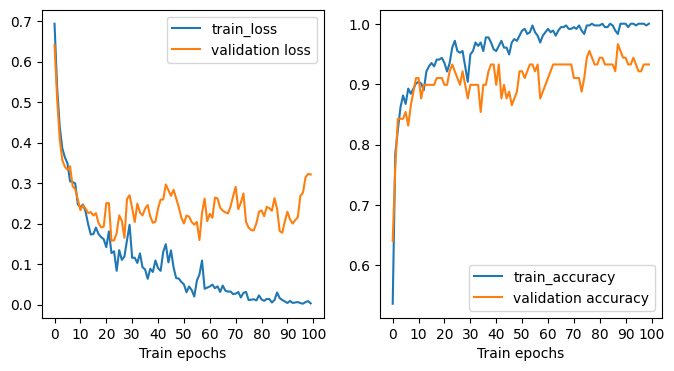

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322542190552
Training...


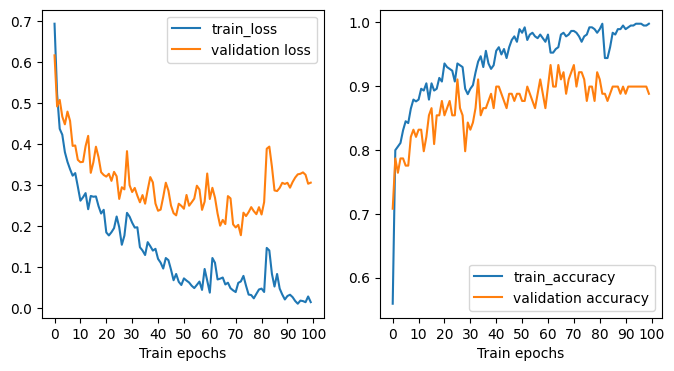

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322542190552
Training...


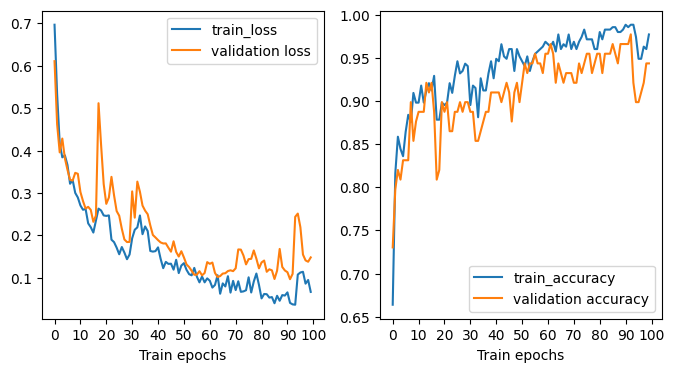

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8817204236984253
Training...


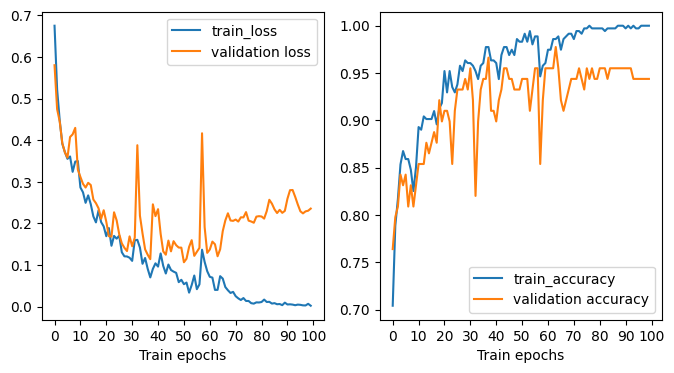

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8870967626571655
Training...


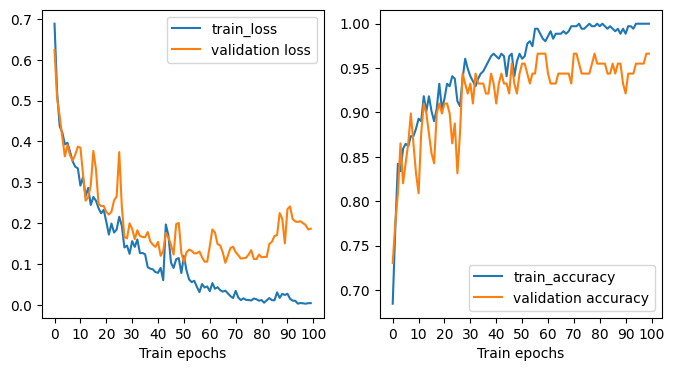

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8887096643447876
Training...


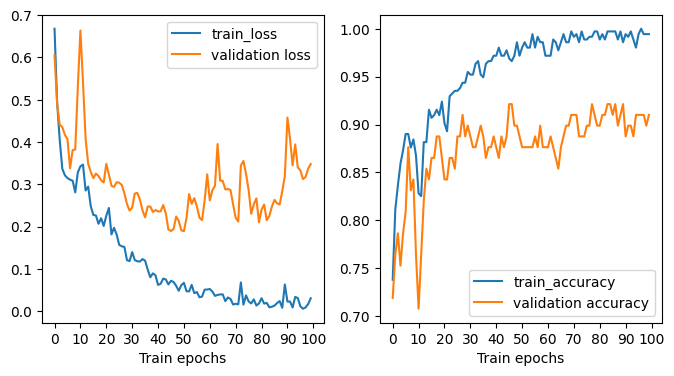

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8803763290246328
Training...


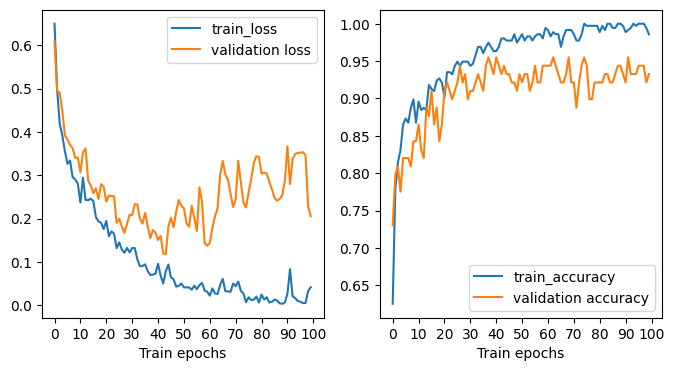

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8790322457041059
Training...


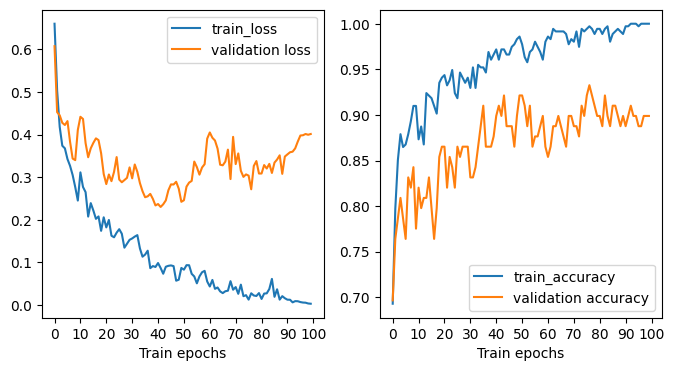

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8800403103232384
Training...


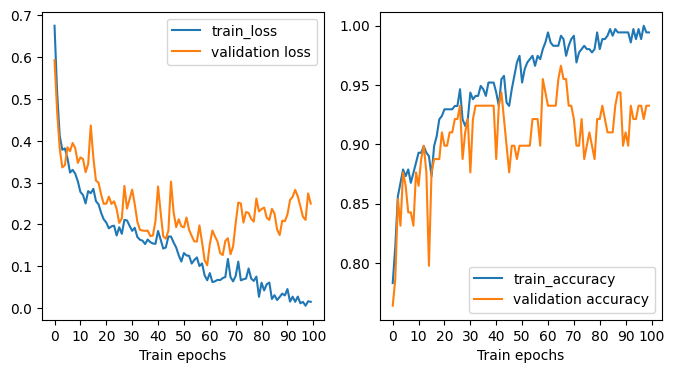

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8781361844804552
Training...


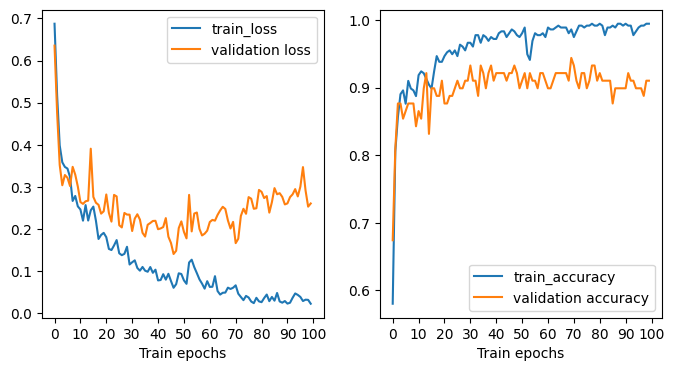

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8782257914543152
Training...


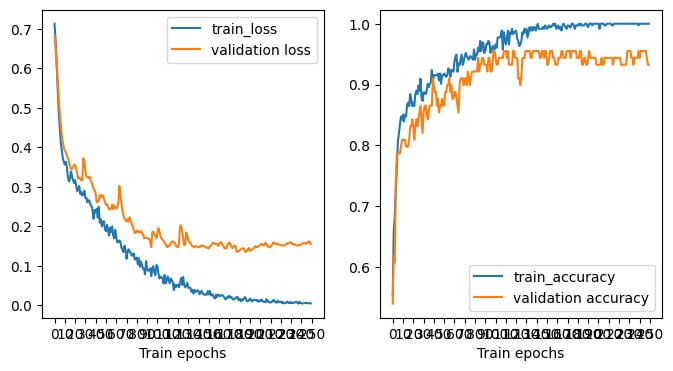

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8951612710952759
Training...


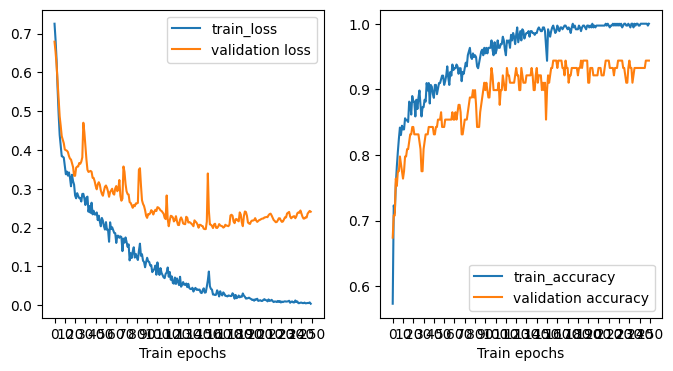

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8830645084381104
Training...


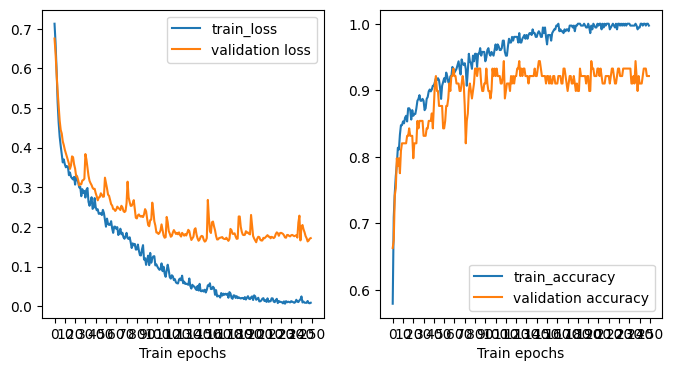

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8844085931777954
Training...


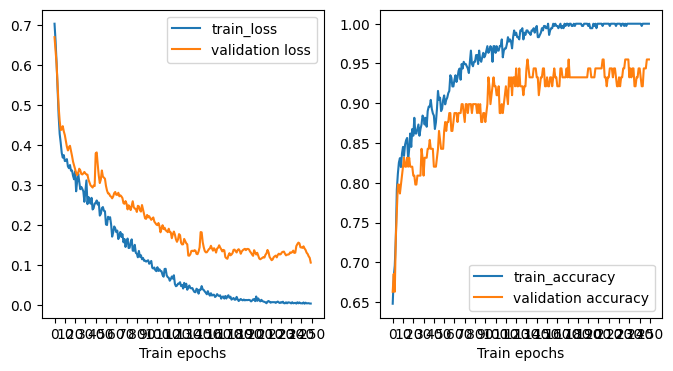

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8850806355476379
Training...


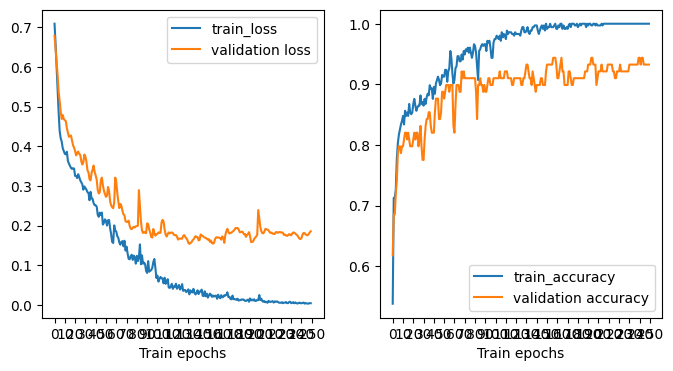

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8854838609695435
Training...


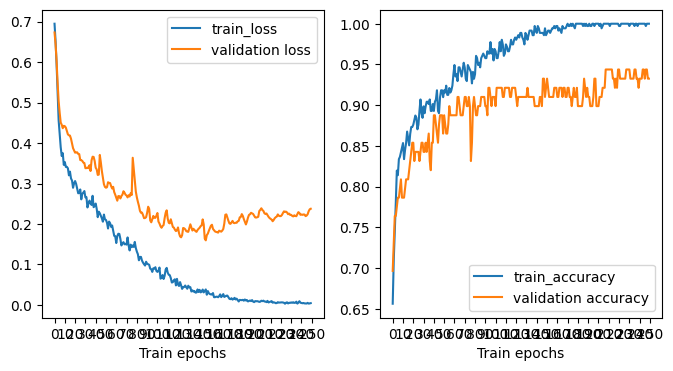

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8884408473968506
Training...


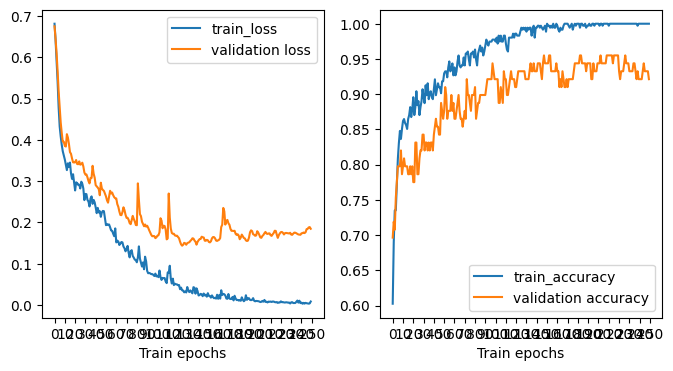

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8870967626571655
Training...


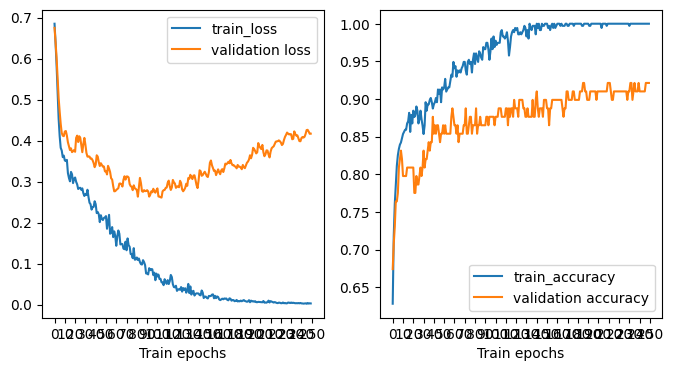

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8881048262119293
Training...


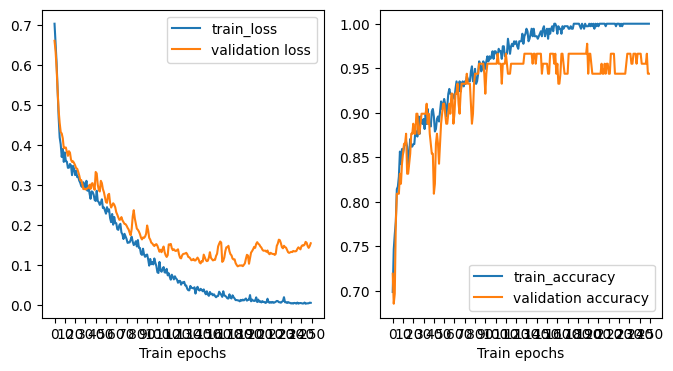

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8853046430481805
Training...


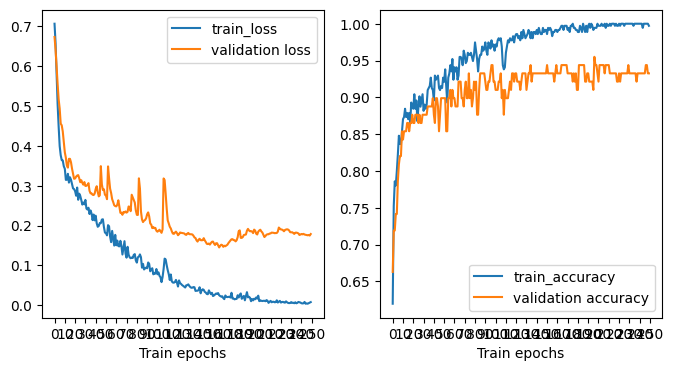

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.88629030585289


In [22]:
# Build Ablation table for accuracy results
# ffnn -> Feed Forward Neural Network 
    #train_and_evaluate(hidden_layer_sizes=[95,10],
    #    activation='relu',
    #    optimizer='Adam',
    #    learning_rate=0.006404687722635315,
    #    dropout_rate=0.25,
    #    num_epochs=100,
    #    num_folds=10)
models = [
    {"name": "Model 1 - FFNN/relu/Adam/hls-95,10/lr-0.0090591/dr-0.1", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.0090591,
    dropout_rate=0.1,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 2 - FFNN/relu/Adam/hls-95,10/lr-0.0090591/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.0090591,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 3 - FFNN/tanh/Adam/hls-95,10/lr-0.0090591/dr-0.1", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0090591,
    dropout_rate=0.1,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 4 - FFNN/tanh/Adam/hls-95,10/lr-0.0090591/dr-0.2", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0090591,
    dropout_rate=0.2,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 5 - FFNN/tanh/Adam/hls-95,10/lr-0.0090591/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0090591,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 6 - FFNN/tanh/Adam/hls-85,10/lr-0.0090591/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[85,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0090591,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 7 - FFNN/tanh/Adam/hls-100,50/lr-0.001244/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[100,50],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001244,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10),
    }
]


In [23]:
study = []
for model_info in models:
    model_name = model_info["name"]
    model = model_info["model"]
    #model.train_and_evaluate(X_train_pca, y_train)
    
    accuracy = model.evaluate(X_test_pca, Y_test)
    study.append({"Model": model_name, "Accuracy": accuracy})

# Create the ablation table using Pandas and tabulate
table_df = pd.DataFrame(study)
ablation_table = tabulate(table_df, headers="keys", tablefmt="pipe")

# Print the ablation table
print(ablation_table)

4/4 [==============================] - 0s 6ms/step - loss: 0.6298 - binary_accuracy: 0.8952
|    | Model                                                    | Accuracy                                  |
|---:|:---------------------------------------------------------|:------------------------------------------|
|  0 | Model 1 - FFNN/relu/Adam/hls-95,10/lr-0.0090591/dr-0.1   | [1.1536809206008911, 0.8387096524238586]  |
|  1 | Model 2 - FFNN/relu/Adam/hls-95,10/lr-0.0090591/dr-0.25  | [1.9979075193405151, 0.8709677457809448]  |
|  2 | Model 3 - FFNN/tanh/Adam/hls-95,10/lr-0.0090591/dr-0.1   | [0.5523383021354675, 0.8709677457809448]  |
|  3 | Model 4 - FFNN/tanh/Adam/hls-95,10/lr-0.0090591/dr-0.2   | [0.44029754400253296, 0.9032257795333862] |
|  4 | Model 5 - FFNN/tanh/Adam/hls-95,10/lr-0.0090591/dr-0.25  | [0.45654240250587463, 0.8870967626571655] |
|  5 | Model 6 - FFNN/tanh/Adam/hls-100,10/lr-0.0090591/dr-0.25 | [0.5429367423057556, 0.8790322542190552]  |
|  6 | Model 7 - FFNN/tanh/A